# Setup notebook

## Install and import libraries

In [75]:
# uncomment below and run if needed, should not be necessary on google colab!

# ! pip install pandas
# ! pip install numpy
# ! pip install scikit-learn
# ! pip install matplotlib
# ! pip install seaborn

In [698]:
import pandas as pd
import numpy as np
import sys
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import seaborn as sns

from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.stats import MonteCarloMethod
from scipy.stats import wilcoxon, kendalltau
from scipy.stats import sem

## Set constants

In [699]:
plt.rcParams['font.family'] = 'Arial'
PRESENCE_CUTOFF = 0.00001

## Download and load up data

In [723]:
%%bash
if [[ ! (-f data/training_set.csv && -f data/longitudinal_cases.csv) ]]; then 
    # remove potentially corrupt zip and data directory
    rm -rf data.zip 
    rm -rf data

    # download data from the repo
    wget https://raw.githubusercontent.com/danielchang2002/GMWI2/main/manuscript/data.zip

    # unzip the data
    ! unzip data.zip
fi

In [706]:
training_set = pd.read_csv("data/training_set.csv", index_col=[0, 1])

In [717]:
longitudinal_cases = pd.read_csv("backup.csv", index_col=[0, 1])

In [724]:
longitudinal_cases

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID       Sample Accession                                            
Palleja (2018) SAMEA104062441      0.000000                     0.000000   
               SAMEA104062442      0.000000                     0.000000   
               SAMEA104062443      0.000000                     0.000000   
               SAMEA104062444      0.000000                     0.000000   
               SAMEA104062445      0.027550                     0.027550   
...                                     ...                          ...   
Lee (2023)     NS0_1               0.000016                     0.000016   
               FS24_1              0.000000                     0.000000   
               NS24_2              0.000000                     0.000000   
               GS24_1              0.000000                     0.000000   
               IN24_1              0.000000                     0.000000   

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID       Sample Accession                                                   
Palleja (2018) SAMEA104062441                                          0.000000   
               SAMEA104062442                                          0.000000   
               SAMEA104062443                                          0.000000   
               SAMEA104062444                                          0.000000   
               SAMEA104062445                                          0.027550   
...                                                                         ...   
Lee (2023)     NS0_1                                                   0.000016   
               FS24_1                                                  0.000000   
               NS24_2                                                  0.000000   
               GS24_1                                                  0.000000   
               IN24_1                                                  0.000000   

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID       Sample Accession                                                                         
Palleja (2018) SAMEA104062441                                             0.000000                      
               SAMEA104062442                                             0.000000                      
               SAMEA104062443                                             0.000000                      
               SAMEA104062444                                             0.000000                      
               SAMEA104062445                                             0.027550                      
...                                                                            ...                      
Lee (2023)     NS0_1                                                      0.000016                      
               FS24_1                                                     0.000000                      
               NS24_2                                                     0.000000                      
               GS24_1                                                     0.000000                      
               IN24_1                                                     0.000000                      

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID       Sample Accession                                                                                                
Palleja (2018) SAMEA104062441                                             0.000000                                             
               SAMEA104062442                                             0.000000                                             
               SAMEA104062443                                             0.000000    

In [725]:
ef = pd.read_csv("../manuscript_raw/output/logs/fmt_effect_noeffect.csv", index_col=0)
ef = ef.reset_index()
ef.columns = ["Sample Accession", "health_status/host_diet"]
ef["Study ID"] = "Goll (2020)"
ef = ef.set_index(["Study ID", "Sample Accession"])
ef

health_status/host_diet
Study ID    Sample Accession                        
Goll (2020) SAMEA7082416                      effect
            SAMEA7082415                      effect
            SAMEA7082414                      effect
            SAMEA7082413                      effect
            SAMEA7082412                      effect
...                                              ...
            SAMEA7082344                   no effect
            SAMEA7082343                   no effect
            SAMEA7082342                      effect
            SAMEA7082341                      effect
            SAMEA7082340                      effect

[66 rows x 1 columns]

In [730]:
goll_cases = longitudinal_cases.loc[["Goll (2020)"]]
goll_fmt = goll_cases.loc[ef.index]
goll_donors = goll_cases[goll_cases["health_status/host_diet"] == "Healthy"]
goll_cases = pd.concat([goll_donors, goll_fmt])

In [734]:
pd.concat([longitudinal_cases.loc[["Palleja (2018)", "Tanes (2021)", "Lee (2023)"]], goll_cases]).to_csv("data/longitudinal_cases.csv")

# Exploratory analysis!

## Pooled dataset phenotypes (Supplementary Fig. 5)

In [10]:
phenotype = training_set[["Phenotype"]]
phenotype

Phenotype
Study_ID            Sample Accession          
Obregon-Tito (2015) SAMN03283239       Healthy
                    SAMN03283266       Healthy
                    SAMN03283281       Healthy
                    SAMN03283294       Healthy
                    SAMN03283288       Healthy
...                                        ...
Yang (2020)         SRR6456373         Healthy
                    SRR6456374         Healthy
                    SRR6456375         Healthy
                    SRR6456376         Healthy
                    SRR6456377         Healthy

[8069 rows x 1 columns]

In [11]:
dataset_stats = phenotype.reset_index().groupby('Phenotype').agg(lambda x: x.nunique())
dataset_stats.columns = ["# of studies", "# of samples"]
dataset_stats

# of studies  # of samples
Phenotype                                                         
Ankylosing spondylitis                             1            95
Atherosclerotic cardiovascular disease             1           214
Colorectal cancer                                  9           789
Crohn's Disease                                    7           284
Graves’ disease                                    1           100
Healthy                                           46          5547
Liver Cirrhosis                                    1           152
MS                                                 1            24
NAFLD                                              1            86
Rheumatoid arthritis                               2           151
Type 2 diabetes                                    4           377
Ulcerative colitis                                 6           250

## Demographic information (Fig. 1a)

In [12]:
demographics = training_set[["Age", "Sex", "Continent"]]
demographics

Age     Sex      Continent
Study_ID            Sample Accession                             
Obregon-Tito (2015) SAMN03283239      13.0     NaN  South America
                    SAMN03283266      32.0  Female  North America
                    SAMN03283281      52.0  Female  South America
                    SAMN03283294       4.0    Male  South America
                    SAMN03283288      12.0    Male  South America
...                                    ...     ...            ...
Yang (2020)         SRR6456373         NaN     NaN            NaN
                    SRR6456374         NaN     NaN            NaN
                    SRR6456375         NaN     NaN            NaN
                    SRR6456376         NaN     NaN            NaN
                    SRR6456377         NaN     NaN            NaN

[8069 rows x 3 columns]

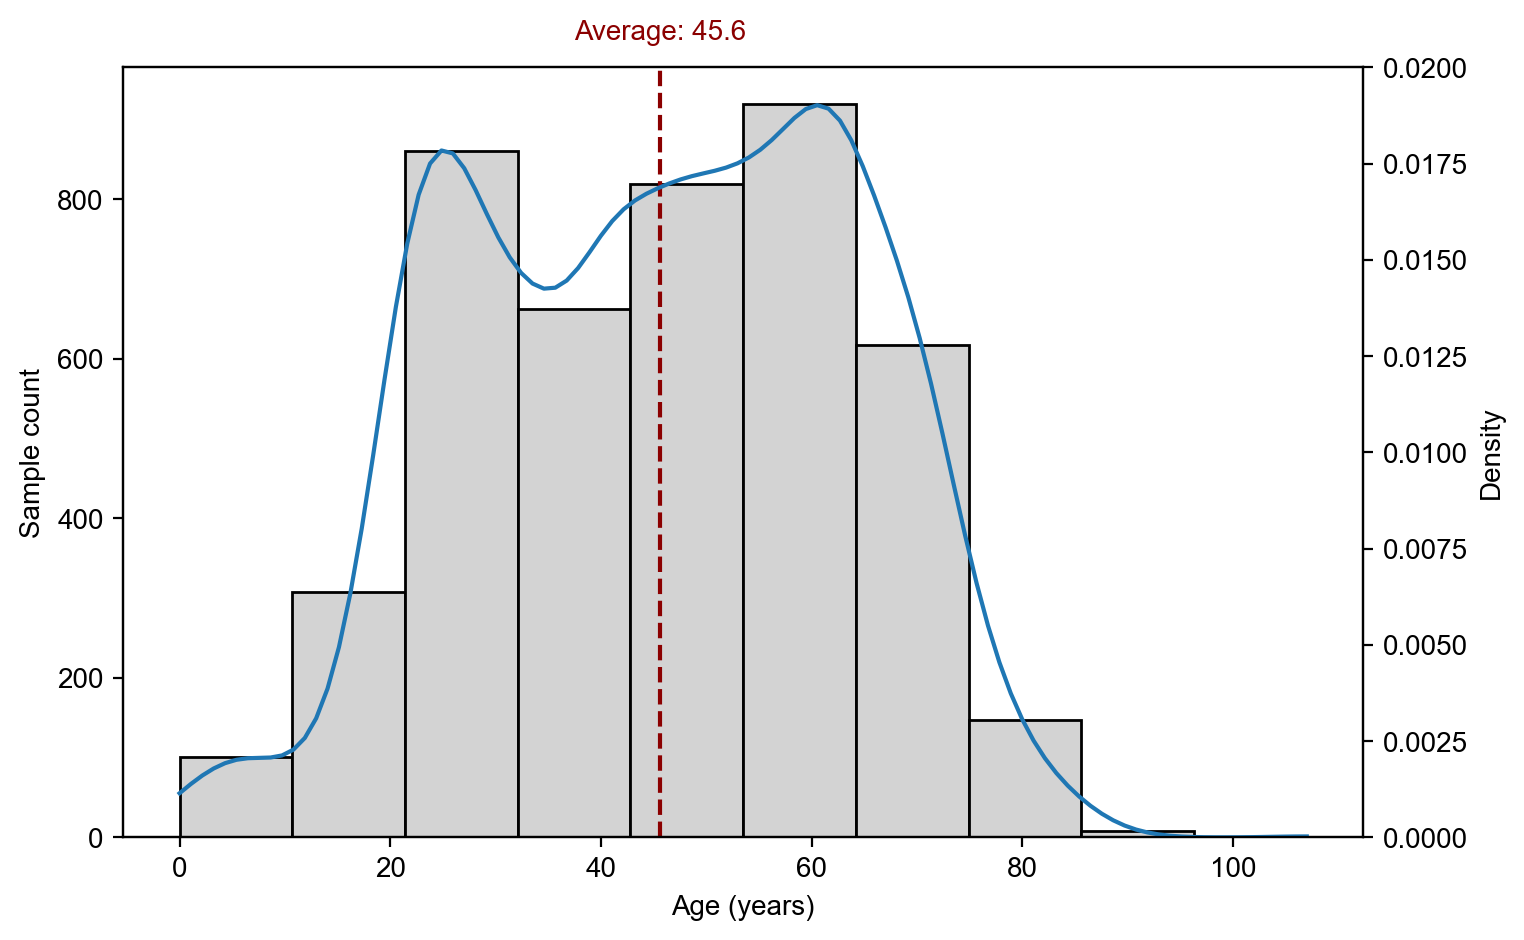

In [13]:
age = demographics[~demographics["Age"].isna()][["Age"]]
mean = float(age.mean())

plt.figure(figsize=(8, 5), dpi=200)
plt.hist(age, edgecolor='k', color='lightgray')

plt.text(mean, 1000, f"Average: {round(mean, 2)}", horizontalalignment='center', color='darkred')
ax = plt.gca()
ax.set_ylabel("Sample count")
ax.set_xlabel("Age (years)")

density = gaussian_kde(age.values.flatten())
lin = np.linspace(age.min(), age.max(), 100)
ax2 = ax.twinx()
ax2.plot(lin, [density(li) for li in lin], zorder=-1)
ax2.set_ylabel("Density")
ax2.set_ylim((0, 0.02))

ax.axline((mean, 0), slope=float('inf'), c='darkred', linestyle="--")
plt.show()

In [14]:
sex = demographics[["Sex"]]
sex_counts = pd.DataFrame(sex.groupby("Sex", dropna=False).size(), columns=["Count"])
sex_counts["Proportion"] = sex_counts["Count"] / sex_counts['Count'].sum()
sex_counts

Count  Proportion
Sex                      
Female   2583    0.320114
Male     2436    0.301896
NaN      3050    0.377990

In [15]:
continent = demographics[["Continent"]]
cont_counts = pd.DataFrame(continent.groupby("Continent", dropna=False).size(), columns=["Count"])
wedges = ax.pie(cont_counts.values.flatten(), labels=cont_counts.index, wedgeprops=dict(width=1), startangle=-40, autopct="%1.1f%%")
cont_counts["Proportion"] = cont_counts["Count"] / cont_counts['Count'].sum()
cont_counts

Count  Proportion
Continent                       
Africa           409    0.050688
Asia            3366    0.417152
Europe          2260    0.280084
North America   1525    0.188995
Oceania           79    0.009791
South America      8    0.000991
NaN              422    0.052299

## Principal Component Analysis (Fig. 1b)

In [16]:
X = training_set[[c for c in training_set.columns if c.startswith("UNK") or c.startswith("k__")]]
X

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID            Sample Accession                                            
Obregon-Tito (2015) SAMN03283239        0.000000                     0.000000   
                    SAMN03283266        0.000000                     0.000000   
                    SAMN03283281        0.009764                     0.009764   
                    SAMN03283294        0.000000                     0.000000   
                    SAMN03283288        0.011865                     0.011865   
...                                          ...                          ...   
Yang (2020)         SRR6456373          0.000000                     0.000000   
                    SRR6456374          0.000000                     0.000000   
                    SRR6456375          0.000000                     0.000000   
                    SRR6456376          0.002415                     0.002415   
                    SRR6456377          0.000000                     0.000000   

                                      k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID            Sample Accession                                                   
Obregon-Tito (2015) SAMN03283239                                            0.000000   
                    SAMN03283266                                            0.000000   
                    SAMN03283281                                            0.009764   
                    SAMN03283294                                            0.000000   
                    SAMN03283288                                            0.011865   
...                                                                              ...   
Yang (2020)         SRR6456373                                              0.000000   
                    SRR6456374                                              0.000000   
                    SRR6456375                                              0.000000   
                    SRR6456376                                              0.002415   
                    SRR6456377                                              0.000000   

                                      k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID            Sample Accession                                                                         
Obregon-Tito (2015) SAMN03283239                                               0.000000                      
                    SAMN03283266                                               0.000000                      
                    SAMN03283281                                               0.009764                      
                    SAMN03283294                                               0.000000                      
                    SAMN03283288                                               0.011865                      
...                                                                                 ...                      
Yang (2020)         SRR6456373                                                 0.000000                      
                    SRR6456374                                                 0.000000                      
                    SRR6456375                                                 0.000000                      
                    SRR6456376                                                 0.002415                      
                    SRR6456377                                                 0.000000                      

                                      k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID            Sample Accession                                                                                                
Obregon-Tito (2015) SAMN03283239                                               0.000000                                             
         

In [17]:
y = training_set[["is_healthy"]]
y

is_healthy
Study_ID            Sample Accession            
Obregon-Tito (2015) SAMN03283239            True
                    SAMN03283266            True
                    SAMN03283281            True
                    SAMN03283294            True
                    SAMN03283288            True
...                                          ...
Yang (2020)         SRR6456373              True
                    SRR6456374              True
                    SRR6456375              True
                    SRR6456376              True
                    SRR6456377              True

[8069 rows x 1 columns]

In [18]:
pca = PCA(random_state=42, n_components=2)
pca.fit(X > PRESENCE_CUTOFF)
PC1_variance, PC2_variance = pca.explained_variance_ratio_[:2] * 100
embedding = pca.transform(X > PRESENCE_CUTOFF)
embedding

array([[ 1.69910132,  5.10700429],
       [ 0.29747153, -1.26331052],
       [-0.14752581,  5.75057233],
       ...,
       [-1.1986457 , -0.80476489],
       [-1.10964835,  0.58300576],
       [ 1.11515779,  1.61157009]])

In [19]:
loading = pd.DataFrame(pca.components_.T, index=X.columns, columns=["PC1", "PC2"])
loading.index = [ind.split("|")[-1] for ind in loading.index]
loading

PC1       PC2
k__Archaea                         -0.090106  0.042917
p__Euryarchaeota                   -0.090106  0.042917
c__Methanobacteria                 -0.090110  0.042939
o__Methanobacteriales              -0.090110  0.042939
f__Methanobacteriaceae             -0.090110  0.042939
...                                      ...       ...
s__Pepper_mild_mottle_virus         0.000006 -0.000171
s__Tobacco_mild_green_mosaic_virus  0.000000 -0.000000
s__Deep_sea_thermophilic_phage_D6E  0.000069  0.000084
s__Loktanella_phage_pCB2051_A       0.000000 -0.000000
s__Tetraselmis_viridis_virus_S1    -0.000085 -0.000040

[3200 rows x 2 columns]

In [20]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

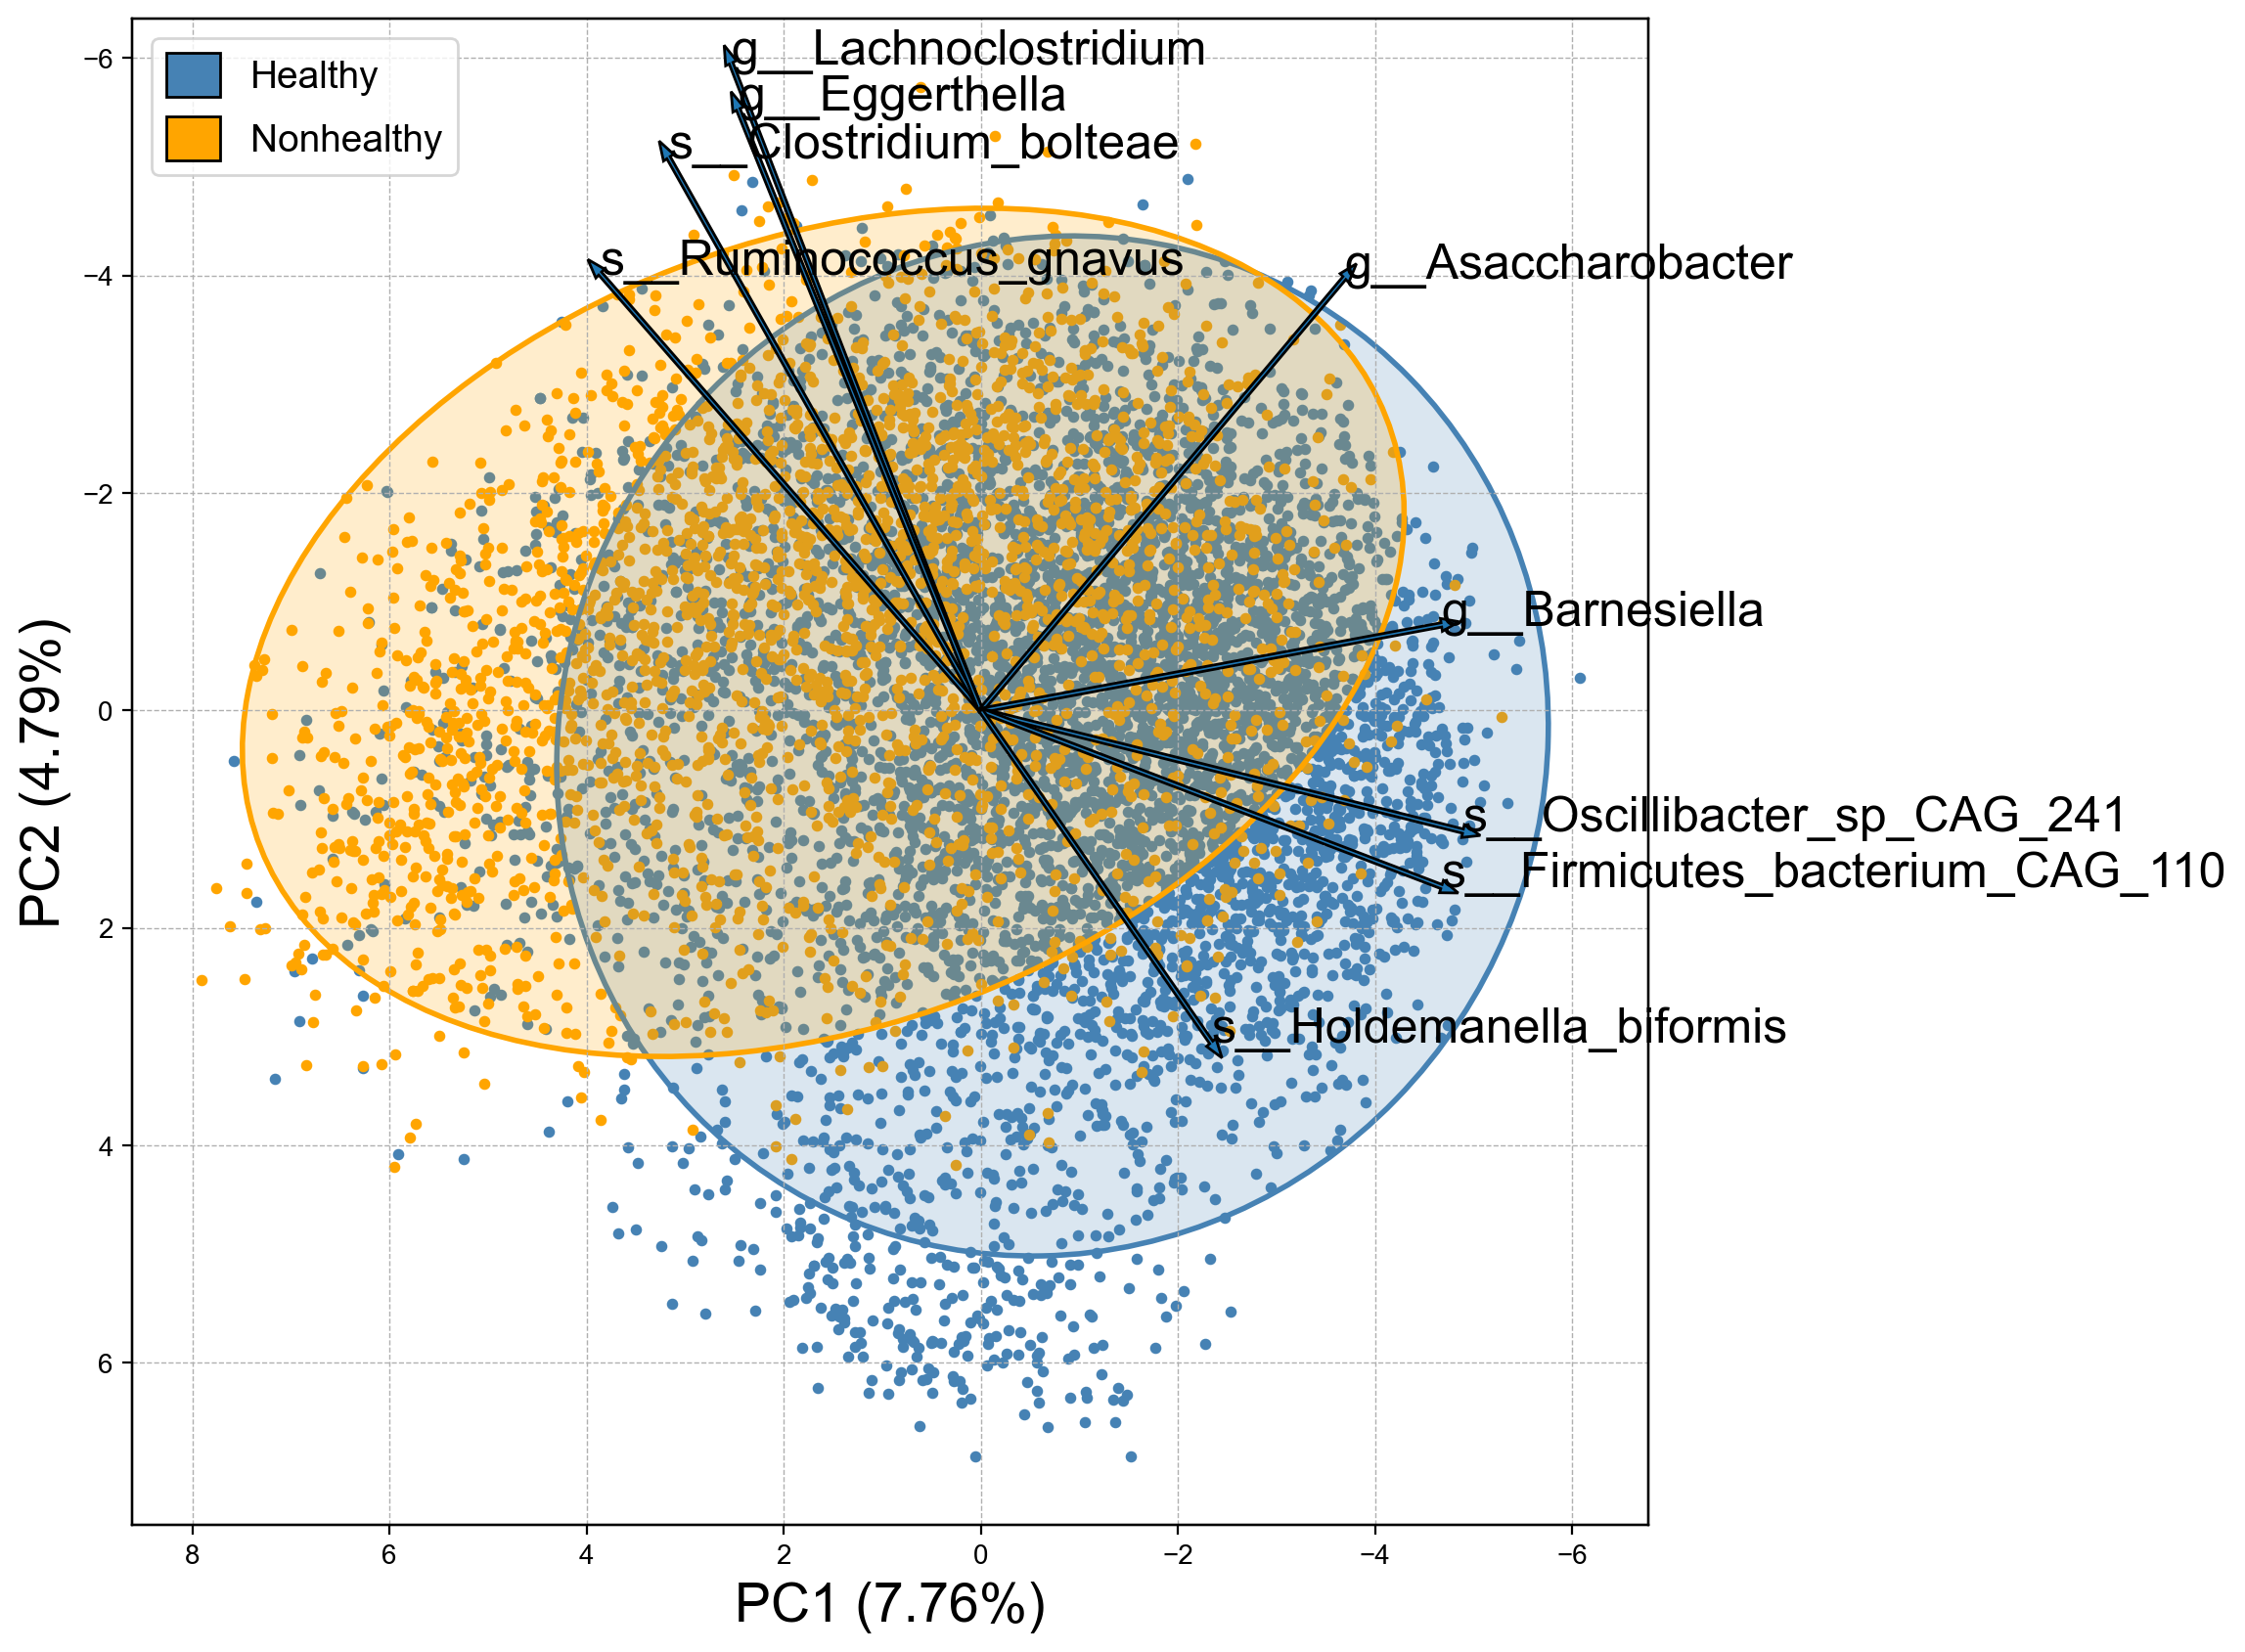

In [24]:
plt.figure(figsize=(10, 10), dpi=200)

ax = plt.gca()

PC1_healthy, PC2_healthy = embedding[y.values.flatten(), 0], embedding[y.values.flatten(), 1]

PC1_nonhealthy, PC2_nonhealthy = embedding[~y.values.flatten(), 0], embedding[~y.values.flatten(), 1]

healthy_color = "steelblue"
nonhealthy_color = "orange"

dot_alpha = 1
dot_size = 10
plt.scatter(PC1_healthy, PC2_healthy, alpha=dot_alpha, s=dot_size, label="Healthy", color=healthy_color)
plt.scatter(PC1_nonhealthy, PC2_nonhealthy, alpha=dot_alpha, s=dot_size, label="Nonhealthy", color=nonhealthy_color)

# 2.25 standard deviations is about 95% confidence in 2D
n_std = 2.25
confidence_ellipse(PC1_healthy, PC2_healthy, plt.gca(), n_std=n_std,
                   alpha=1, edgecolor=healthy_color, lw=2)
confidence_ellipse(PC1_healthy, PC2_healthy, plt.gca(), n_std=n_std,
                   alpha=0.2, facecolor=healthy_color)

confidence_ellipse(PC1_nonhealthy, PC2_nonhealthy, plt.gca(), n_std=n_std,
                   alpha=1, edgecolor=nonhealthy_color, lw=2)
confidence_ellipse(PC1_nonhealthy, PC2_nonhealthy, plt.gca(), n_std=n_std,
                   alpha=0.2, facecolor=nonhealthy_color)

plt.xlabel(f"PC1 ({'{:.2f}'.format(PC1_variance)}%)", fontsize=20)
plt.ylabel(f"PC2 ({'{:.2f}'.format(PC2_variance)}%)", fontsize=20)

handles = [
    Patch(facecolor=healthy_color, edgecolor="k", label="Healthy"),
    Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy"),
]

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(handles=handles, prop={'size': 14}, loc=2, handlelength=1.4, handleheight=1.4)

# plot loading factors

twinx = ax.twinx()

ax_new = twinx.twiny()

loading_taxa = [
    "s__Ruminococcus_gnavus",
    "s__Clostridium_bolteae",
    "g__Lachnoclostridium",
    "g__Eggerthella",
    "g__Asaccharobacter",
    "g__Barnesiella",
    "s__Oscillibacter_sp_CAG_241",
    "s__Firmicutes_bacterium_CAG_110",
    "s__Holdemanella_biformis"
]

for t in loading_taxa:
    pc1, pc2 = loading["PC1"].loc[t], loading["PC2"].loc[t]
    ax_new.arrow(0, 0, pc1, pc2)
    ax_new.text(pc1, pc2, t, fontsize=18)

scale = 0.025

ax_new.set_xlim(x_min * scale, x_max * scale)
ax_new.set_ylim(y_min * scale, y_max * scale)

ax_new.tick_params(
    axis='x',
    which='both',
    top=False,
    labeltop=False,
)

twinx.tick_params(
    axis='y',
    which='both',
    right=False,
    labelright=False,
)

ax.invert_xaxis()
ax.invert_yaxis()

ax_new.invert_xaxis()
ax_new.invert_yaxis()

# Model selection and training!

## Hyperparameter tuning (Supplementary Table 8)

In [25]:
# indentify groups to partition dataset

sample_studies = np.array(X.index.get_level_values(0))
o = OrdinalEncoder()
groups = o.fit_transform(sample_studies.reshape((len(sample_studies), 1))).flatten()
logo = LeaveOneGroupOut()

In [255]:
hyperparam_results = {}

for reg in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]:
    gmwi2 = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=reg, class_weight="balanced")

    # generate logit predictions for each left out study
    GMWI2_scores_ISV = cross_val_predict(gmwi2, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
        groups=groups, cv=logo, verbose=-1, n_jobs=-1
    )
    
    bal = balanced_accuracy_score(y, GMWI2_scores_ISV > 0)
    hyperparam_results[reg] = bal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out

In [262]:
hyperparam_df = pd.DataFrame(hyperparam_results, index=["Balanced accuracy"]).T
hyperparam_df

Balanced accuracy
0.001           0.500000
0.003           0.708903
0.010           0.742525
0.030           0.757593
0.100           0.741353
0.300           0.727169
1.000           0.713923
3.000           0.695917

In [27]:
REGULARIZATION = hyperparam_df.sort_values("Balanced accuracy").index[-1]
REGULARIZATION

0.03

## Train GMWI2 and GMWI and evaluate on training set

In [78]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

class GMWI(BaseEstimator):

    def __init__(self, use_shannon=False, theta_f=1, theta_d=0):
        self.use_shannon = use_shannon
        self.fitted = False
        self.thresh = 0.00001
        self.health_abundant = None
        self.health_scarce = None
        self.features = None
        self.theta_f = theta_f
        self.theta_d = theta_d

    def fit(self, X, y):
        """
        Identifies health_abundant and health_scarce
        columns/features
        """
        self.features = X.columns
        self.classes_ = np.unique(y)
        if(isinstance(X, pd.DataFrame)):
            X = X.values
        if(isinstance(y, pd.DataFrame)):
            y = y.values
        self.fitted = True
        difference, fold_change = self.get_proportion_comparisons(X, y)
        self.select_features(difference, fold_change)

    def get_proportion_comparisons(self, X, y):
        # get healthy and unhealthy samples
        healthies = X[y.flatten(), :]
        unhealthies = X[~y.flatten(), :]

        # get proportions for each species
        proportion_healthy = self.get_proportions(healthies)
        proportion_unhealthy = self.get_proportions(unhealthies)

        # get differences and fold change
        diff = proportion_healthy - proportion_unhealthy
        fold = proportion_healthy / proportion_unhealthy
        return diff, fold

    def get_proportions(self, samples_of_a_class):
        num_samples = samples_of_a_class.shape[0]
        p = np.sum(samples_of_a_class > self.thresh, axis=0) / num_samples
        return p

    def select_features(self, difference, fold_change):
        # based on proportion differences and fold change, select health abundant
        # and health scarce
        self.health_abundant = self.features[self.cutoff(difference, fold_change)]
        self.health_scarce = self.features[self.cutoff(-1 * difference, 1 / fold_change)]

    def cutoff(self, diff, fold):
        diff_cutoff = diff > self.theta_d
        fold_cutoff = fold > self.theta_f
        both_cutoff = np.bitwise_and(diff_cutoff, fold_cutoff)
        columns = np.where(both_cutoff)
        return columns[0]

    def decision_function(self, X):
        if not self.fitted:
            return None
        if list(X.columns) != list(self.features):
            raise Exception("Model was trained with (different) feature names than input")
        # if(isinstance(X, pd.DataFrame)):
        #    X = X.values
        X_healthy_features = X[self.health_abundant]
        X_unhealthy_features = X[self.health_scarce]
        psi_MH = self.get_psi(X_healthy_features.values) / (
            X_healthy_features.shape[1])
        psi_MN = self.get_psi(X_unhealthy_features.values) / (
            (X_unhealthy_features.shape[1]))
        num = psi_MH + self.thresh
        dem = psi_MN + self.thresh
        return np.log10(num / dem)

    def get_psi(self, X):
        psi = self.richness(X) * 1.0
        if self.use_shannon:
            shan = self.shannon(X)
            psi *= shan
        return psi

    def richness(self, X):
        """
        Returns the number of nonzero values for each sample (row) in X
        """
        rich = np.sum(X > self.thresh, axis=1)
        return rich

    def shannon(self, X):
        logged = np.log(X)
        logged[logged == -np.inf] = 0
        logged[logged == np.inf] = 0
        shan = logged * X * -1
        return np.sum(shan, axis=1)

    def predict(self, X):
        return self.decision_function(X) > 0

In [28]:
# use same parameters as original paper
gmwi = GMWI(use_shannon=True, theta_f=1.4, theta_d=0.1)

# use only non-viral species
X_GMWI = X.copy()
X_GMWI = X_GMWI[list(filter(lambda x : "s__" in x and "virus" not in x, X_GMWI.columns))]

gmwi.fit(X_GMWI, y)
GMWI_scores = pd.DataFrame(gmwi.decision_function(X_GMWI), index=y.index, columns=["GMWI"])
display(GMWI_scores)
print("GMWI balanced_accuracy on training set:", balanced_accuracy_score(y, GMWI_scores > 0))

GMWI
Study_ID            Sample Accession          
Obregon-Tito (2015) SAMN03283239      3.832094
                    SAMN03283266      1.758548
                    SAMN03283281      3.341858
                    SAMN03283294      1.429055
                    SAMN03283288      1.064592
...                                        ...
Yang (2020)         SRR6456373       -4.472053
                    SRR6456374       -2.158801
                    SRR6456375        0.280615
                    SRR6456376        1.132266
                    SRR6456377       -0.305132

[8069 rows x 1 columns]

GMWI balanced_accuracy on training set: 0.7172501242714733


In [29]:
gmwi2 = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")
X_GMWI2 = X > PRESENCE_CUTOFF
gmwi2.fit(X_GMWI2, y.values.flatten())
GMWI2_scores = pd.DataFrame(gmwi2.decision_function(X_GMWI2), index=y.index, columns=["GMWI2"])
display(GMWI2_scores)
print("GMWI2 balanced_accuracy on training set:", balanced_accuracy_score(y, GMWI2_scores > 0))

GMWI2
Study_ID            Sample Accession          
Obregon-Tito (2015) SAMN03283239      1.835237
                    SAMN03283266      0.103722
                    SAMN03283281      1.116329
                    SAMN03283294      1.758818
                    SAMN03283288      1.675791
...                                        ...
Yang (2020)         SRR6456373       -1.029233
                    SRR6456374       -0.941967
                    SRR6456375       -0.030621
                    SRR6456376        0.973798
                    SRR6456377       -0.066339

[8069 rows x 1 columns]

GMWI2 balanced_accuracy on training set: 0.7988526637127441


# Model performance analysis 

## Correlation between GMWI2 and GMWI (Supplementary Fig. 1)

PearsonRResult(statistic=0.8089177843242584, pvalue=0.0002)


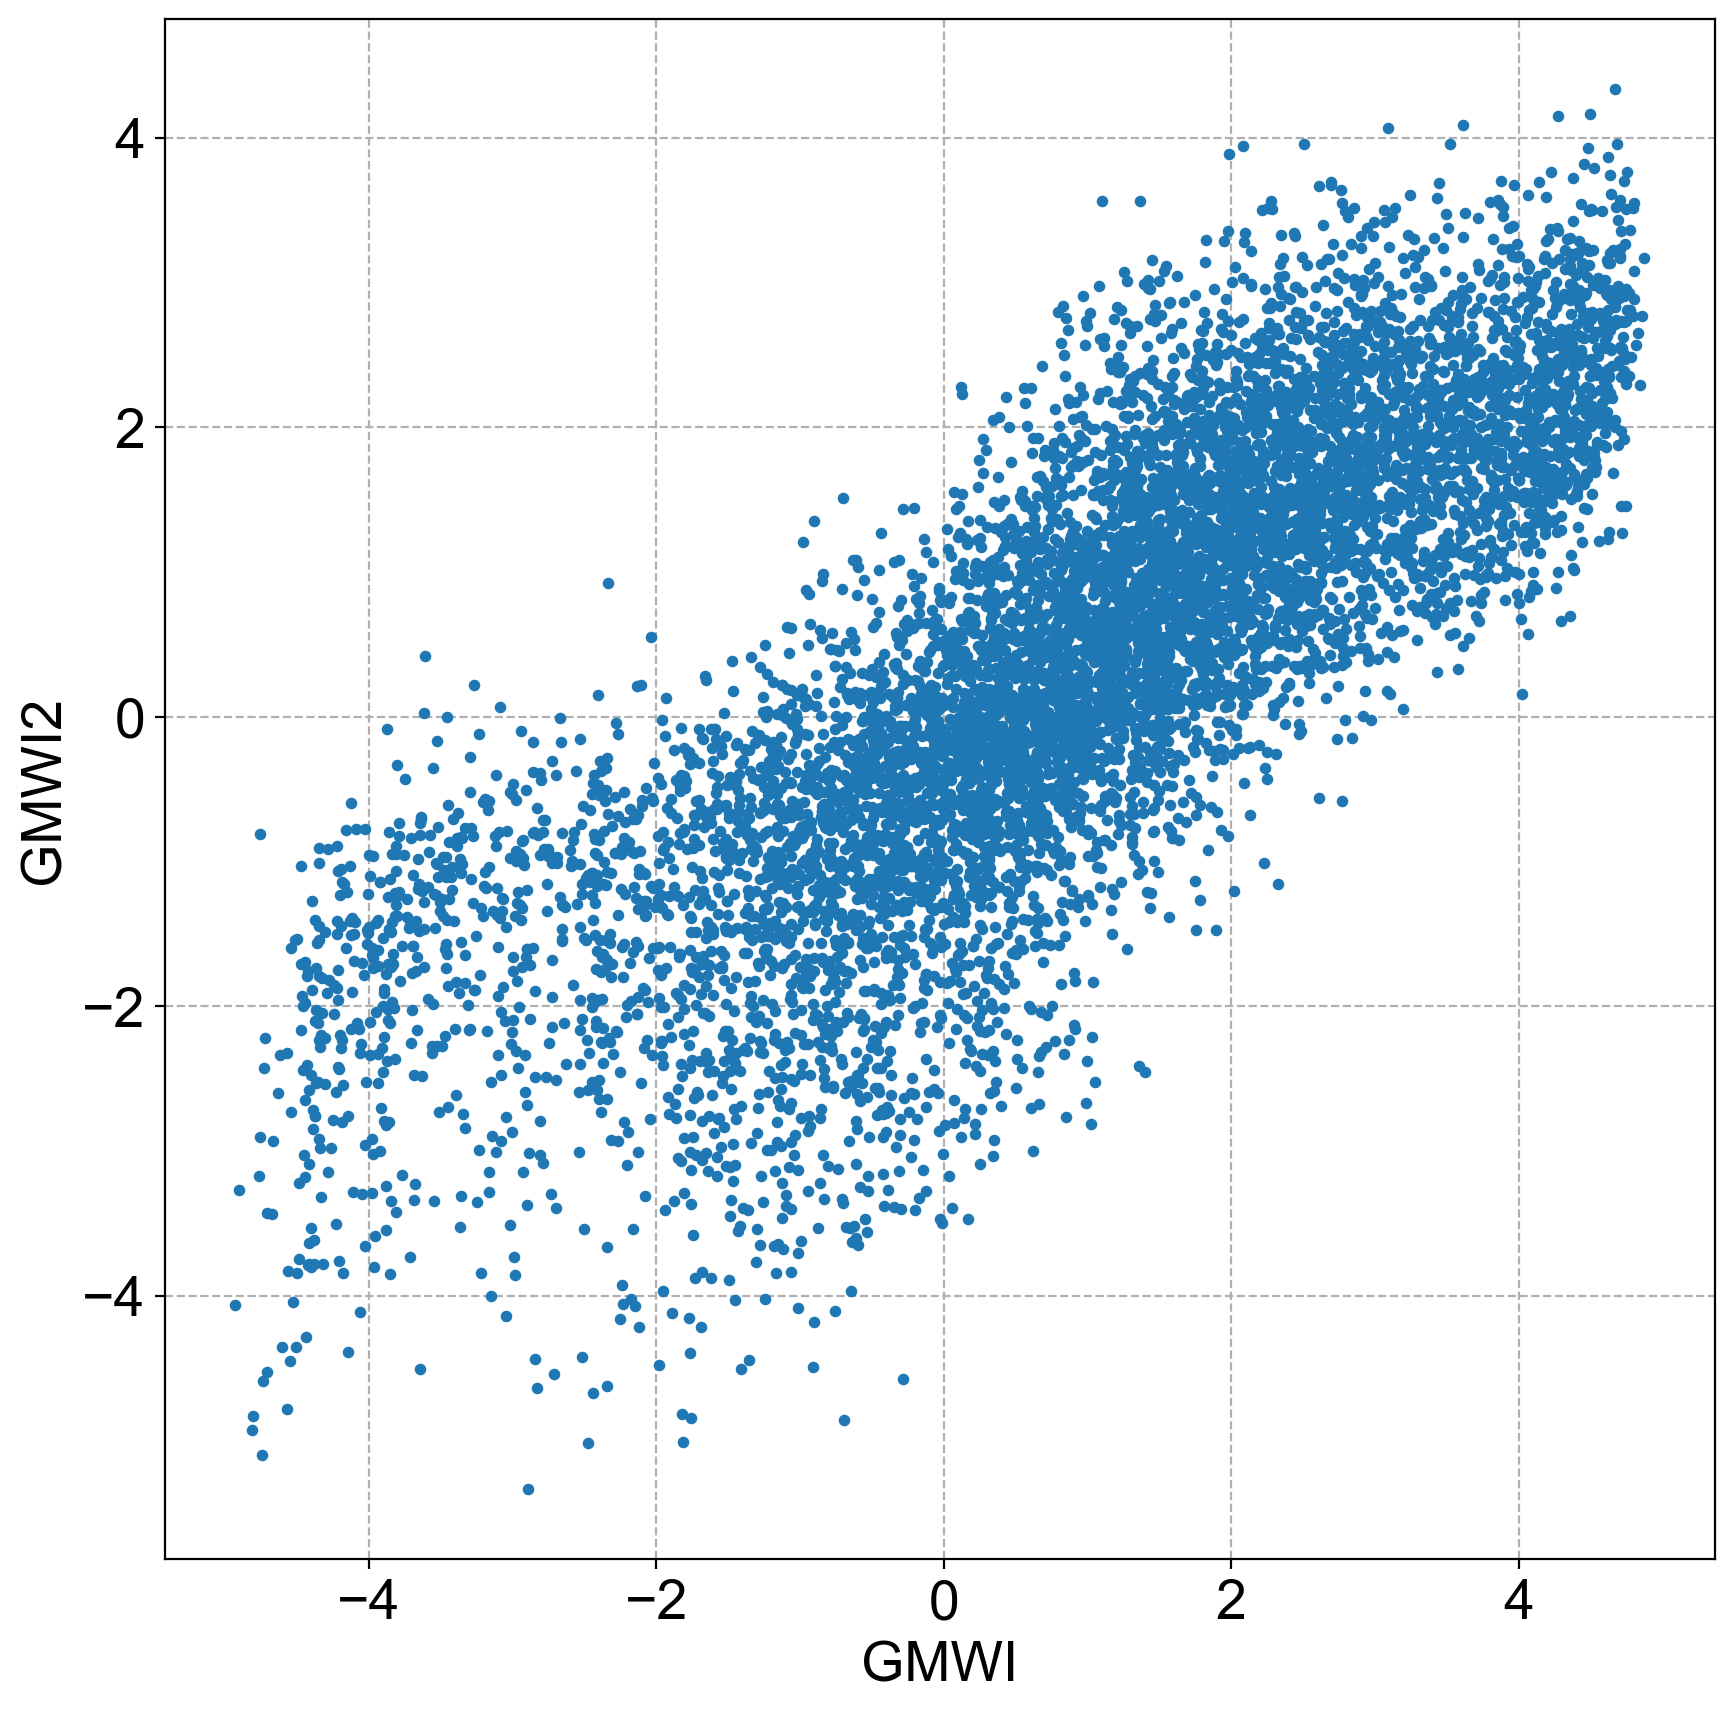

In [30]:
plt.figure(figsize=(10, 10), dpi=200)
plt.grid(True, linestyle='--')

plt.scatter(GMWI_scores, GMWI2_scores, s=10)
plt.xlabel("GMWI", fontsize=20)
plt.ylabel("GMWI2", fontsize=20)
print(pearsonr(GMWI_scores.values.flatten(), GMWI2_scores.values.flatten(), method=MonteCarloMethod()))

tickfont = 20
plt.xticks(fontsize=tickfont)
plt.yticks(fontsize=tickfont)

ax = plt.gca()

ax.set_axisbelow(True)

## GMWI2 model coefficients (Fig. 1c, Supplementary data 2)

In [470]:
coefficients = pd.DataFrame(gmwi2.coef_.flatten(), index=gmwi2.feature_names_in_, columns=["Coefficient"])
sorted_coefficients = coefficients.sort_values("Coefficient", ascending=False)
sorted_coefficients

Coefficient
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactoba...     0.538146
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clos...     0.383497
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clos...     0.329616
k__Bacteria|p__Actinobacteria|c__Actinobacteria...     0.288014
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clos...     0.276186
...                                                         ...
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactoba...    -0.481215
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clos...    -0.518964
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clos...    -0.561698
k__Bacteria|p__Firmicutes|c__Negativicutes|o__V...    -0.589064
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clos...    -0.680591

[3200 rows x 1 columns]

In [32]:
num_pos = (sorted_coefficients > 0).sum().sum()
num_neg = (sorted_coefficients < 0).sum().sum()
num_zero = (sorted_coefficients == 0).sum().sum()
num_coef = sorted_coefficients.shape[0]
buffer = 5
print(f"We have {num_pos} positive coefficients, {num_neg} negative coefficients, and {num_zero} zero coefficients")
print(f"{num_coef} coefficients in total")

We have 49 positive coefficients, 46 negative coefficients, and 3105 zero coefficients
3200 coefficients in total


In [33]:
healthy_color = "steelblue"
zero_color = "darkviolet"
nonhealthy_color = 'orange'

colors = [healthy_color if x > 0 else nonhealthy_color if x < 0 else zero_color
    for x in sorted_coefficients.values.flatten()]

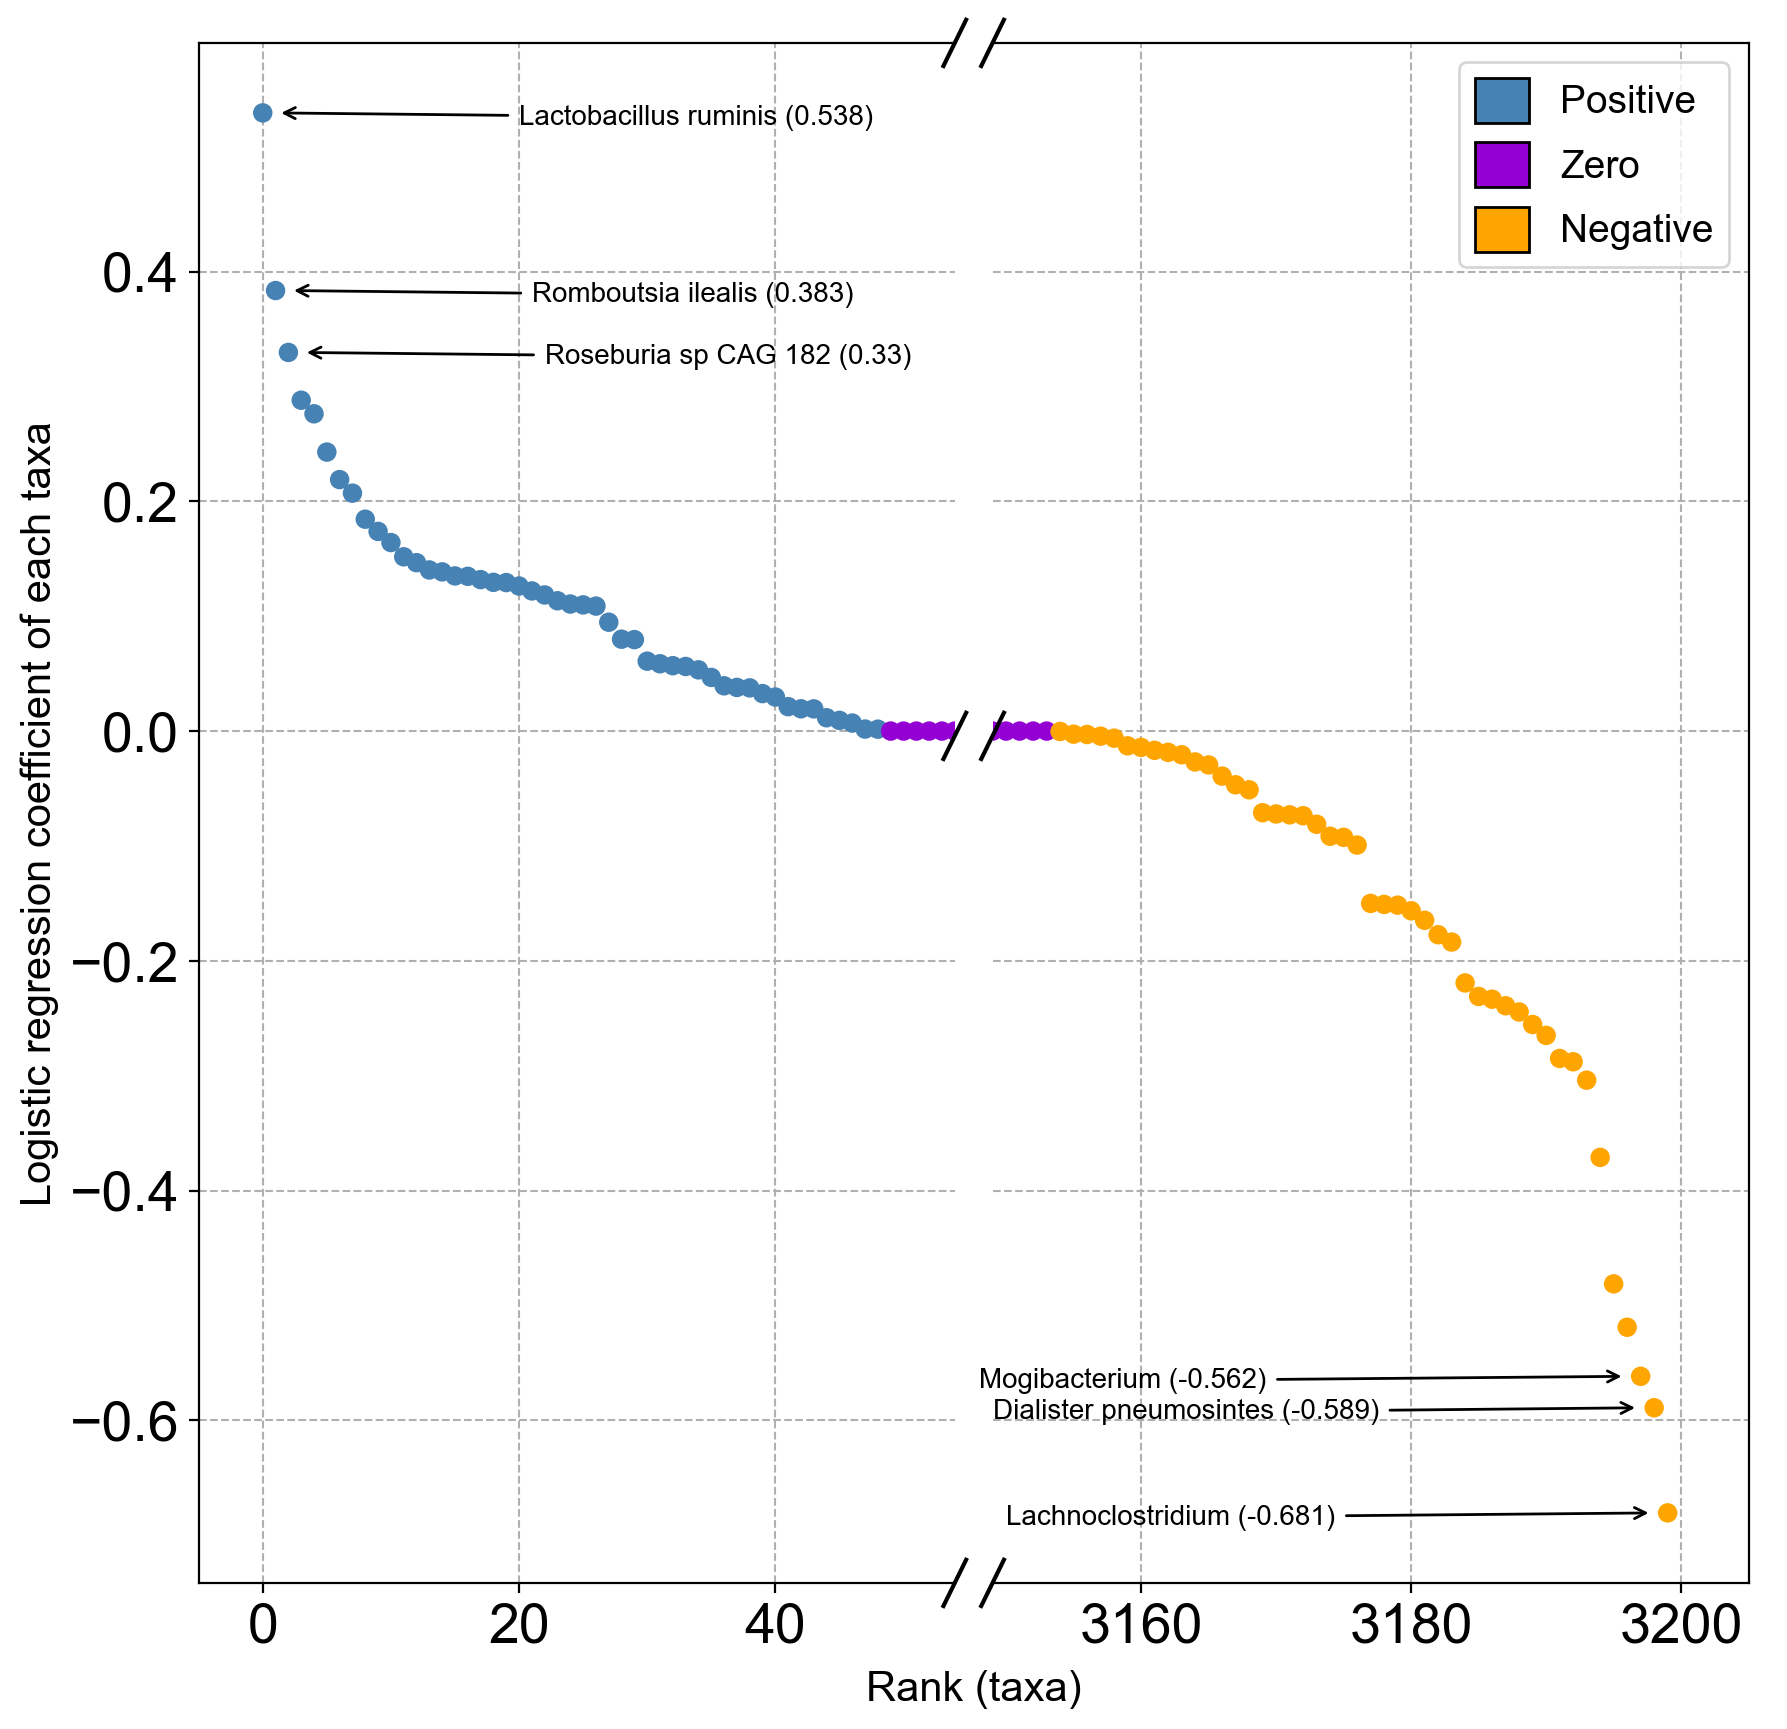

In [34]:
# Create two plots side by side with a shared y
fig, (ax, ax2) = plt.subplots(1,2, sharey=True, facecolor='w', figsize=(10, 10), dpi=200)

# plot the same data on each plot
axes = [ax, ax2]
for i, a in enumerate(axes):
    # give us a nice grid
    a.set_axisbelow(True)
    a.grid(linestyle = '--', linewidth = 0.75)
    
    # set the y label for the left plot
    if i == 0:
        a.set_ylabel("Logistic regression coefficient of each taxa", fontsize=15)
        
    # Big ticks
    a.tick_params(axis="both", labelsize=20)
    
    # plot the coefficients
    a.scatter(np.arange(sorted_coefficients.shape[0]), sorted_coefficients, c=colors)
    
# Broken axis effect
ax.set_xlim(-5, num_pos + buffer)
ax2.set_xlim(num_coef - num_neg - buffer, num_coef + 5)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)


# Make the broken axis diagonal lines
d = .015

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)

middle_diag = 0.55
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (middle_diag - d, middle_diag + d), **kwargs)  # middle-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (-d, +d), **kwargs)        # bottom-right diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-right diagonal
ax2.plot((-d, +d), (middle_diag - d, middle_diag + d), **kwargs)  # middle-right diagonal

fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Rank (taxa)", fontsize=15, labelpad=15)

fig.subplots_adjust(wspace=0.05)

# annotate high magnitude coeffcients (pos and neg)
for i in range(3):
    x, y = i, float(sorted_coefficients.iloc[i])
    taxa = sorted_coefficients.index[i].split("__")[-1].replace("_", " ")
    ax.annotate(r"" + taxa + '' + f" ({round(y, 3)})", xy=(x + 1, y), xytext=(x + 20, y - 0.01),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                fontsize=10
    )
    
for i in range(3):
    idx = -(1 + i)
    x, y = i, float(sorted_coefficients.iloc[idx])
    x = num_coef - x
    taxa = sorted_coefficients.index[idx].split("__")[-1].replace("_", " ")
    ax2.annotate(r"" + taxa + '' + f" ({round(y, 3)})", xy=(x - 2, y), xytext=(x - 50, y - 0.01),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                fontsize=10
    )
    
# Add legend
handles = [
    Patch(facecolor=healthy_color, edgecolor="k", label="Positive", alpha=1),
    Patch(facecolor=zero_color, edgecolor="k", label="Zero", alpha=1),
    Patch(facecolor=nonhealthy_color, edgecolor="k", label="Negative", alpha=1),
]

plt.legend(handles=handles, prop={'size': 14}, loc=1, handlelength=1.4, handleheight=1.4)
    

## Compute indices on the pooled dataset (Fig. 1c, Supplementary data 3)

In [35]:
# compute alpha diversity
X_species = X[list(filter(lambda x : "s__" in x, X.columns))]
richness = pd.DataFrame((X_species > PRESENCE_CUTOFF).sum(axis=1), columns=["Species Richness"])
shannon = pd.DataFrame(np.sum((-X_species * np.log(X_species)).fillna(0), axis=1), columns=["Shannon Diversity"])
simpson = pd.DataFrame(1 - np.sum(X_species ** 2, axis=1), columns=["Simpson Diversity"])

In [36]:
y = training_set[["is_healthy"]]

num_healthy = y.values.sum()
num_nonhealthy = y.shape[0] - y.values.sum()
num_healthy, num_nonhealthy

(5547, 2522)

In [37]:
healthy_nonhealthy = y.copy()
healthy_nonhealthy.columns = ["Health status"]
healthy_text = f"Healthy\n ({num_healthy})"
nonhealthy_text = f"Nonhealthy\n ({num_nonhealthy})"
healthy_nonhealthy[y.values] = healthy_text
healthy_nonhealthy[~y.values] = nonhealthy_text

data = pd.concat([GMWI2_scores, GMWI_scores, healthy_nonhealthy, richness, shannon, simpson], axis=1)
data

GMWI2      GMWI     Health status  \
Study_ID            Sample Accession                                         
Obregon-Tito (2015) SAMN03283239      1.835237  3.832094  Healthy\n (5547)   
                    SAMN03283266      0.103722  1.758548  Healthy\n (5547)   
                    SAMN03283281      1.116329  3.341858  Healthy\n (5547)   
                    SAMN03283294      1.758818  1.429055  Healthy\n (5547)   
                    SAMN03283288      1.675791  1.064592  Healthy\n (5547)   
...                                        ...       ...               ...   
Yang (2020)         SRR6456373       -1.029233 -4.472053  Healthy\n (5547)   
                    SRR6456374       -0.941967 -2.158801  Healthy\n (5547)   
                    SRR6456375       -0.030621  0.280615  Healthy\n (5547)   
                    SRR6456376        0.973798  1.132266  Healthy\n (5547)   
                    SRR6456377       -0.066339 -0.305132  Healthy\n (5547)   

                                      Species Richness  Shannon Diversity  \
Study_ID            Sample Accession                                        
Obregon-Tito (2015) SAMN03283239                    51           2.429760   
                    SAMN03283266                    76           2.711069   
                    SAMN03283281                    74           2.885216   
                    SAMN03283294                    94           2.533818   
                    SAMN03283288                   113           3.133189   
...                                                ...                ...   
Yang (2020)         SRR6456373                      73           2.393276   
                    SRR6456374                      80           2.682308   
                    SRR6456375                      90           2.734653   
                    SRR6456376                      89           2.763858   
                    SRR6456377                      77           1.725367   

                                      Simpson Diversity  
Study_ID            Sample Accession                     
Obregon-Tito (2015) SAMN03283239               0.803097  
                    SAMN03283266               0.880476  
                    SAMN03283281               0.903475  
                    SAMN03283294               0.841909  
                    SAMN03283288               0.901469  
...                                                 ...  
Yang (2020)         SRR6456373                 0.829690  
                    SRR6456374                 0.906057  
                    SRR6456375                 0.933497  
                    SRR6456376                 0.934235  
                    SRR6456377                 0.606075  

[8069 rows x 6 columns]

In [38]:
def observeDifference(a, b):
    u, man_whitney_u_p_val = mannwhitneyu(a, b)
    cliffs_delta = (2 * u) / (a.shape[0] * b.shape[0]) - 1
    return cliffs_delta, man_whitney_u_p_val

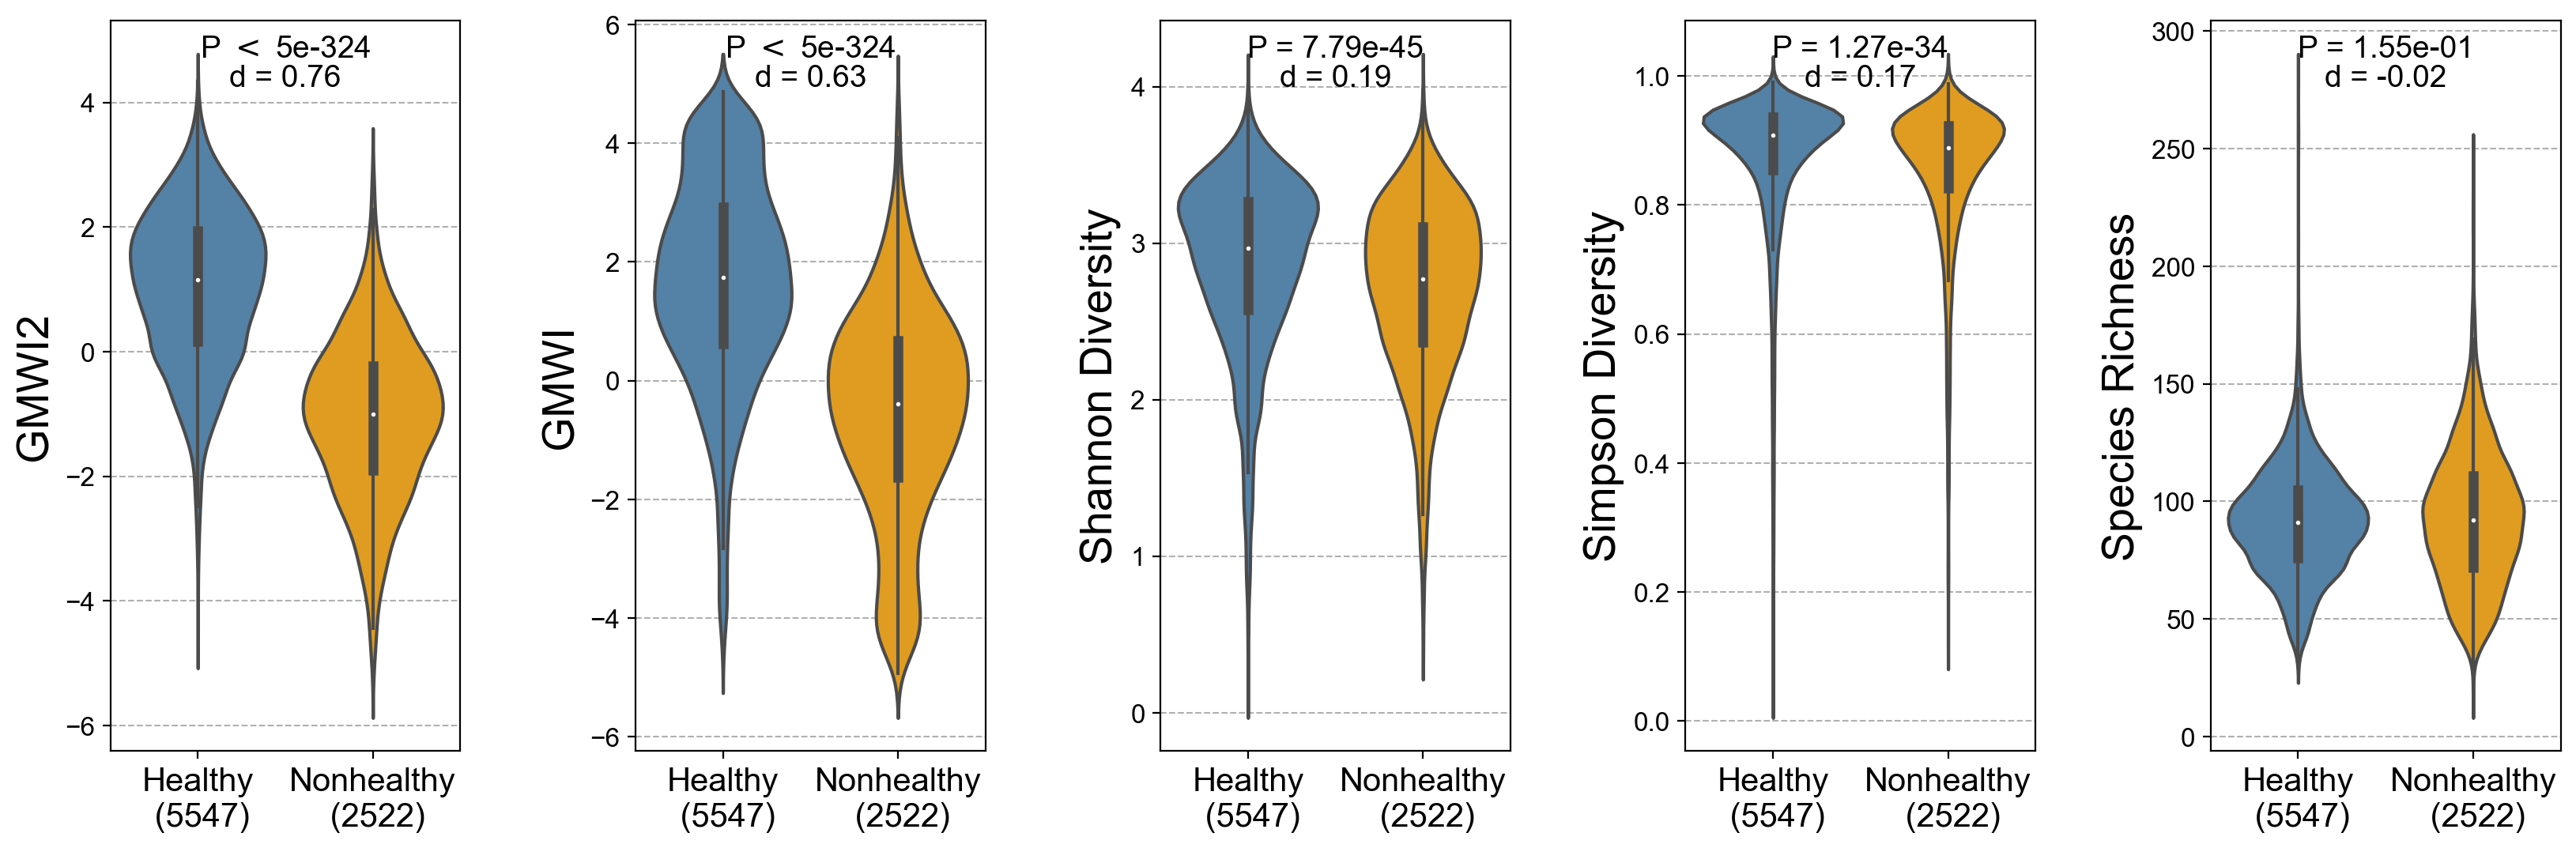

In [39]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 6), dpi=200)
indices = ["GMWI2", "GMWI", "Shannon Diversity", "Simpson Diversity", "Species Richness"]
for ind, ax in zip(indices, axs):
    v = sns.violinplot(x="Health status", y=ind, data=data, ax=ax, 
                   palette={healthy_text : healthy_color, nonhealthy_text : nonhealthy_color})
    cliffs_delta, man_whitney_u_p_val = observeDifference(data[ind].iloc[y.values], data[ind].iloc[~y.values])
    
    p_text = (r"P $<$ " + str(np.nextafter(0, 1))) if man_whitney_u_p_val == 0 else (
        r"P = " + str(np.format_float_scientific(man_whitney_u_p_val, precision=2))
    )
    
    ax.text(0.5, 0.95, p_text, fontsize=14,
        horizontalalignment='center', transform=ax.transAxes
    )
    ax.text(0.5, 0.91, f"d = {'%.2f' % cliffs_delta}", fontsize=14,
        horizontalalignment='center', transform=ax.transAxes
    )
    
    v.tick_params(axis="y", labelsize=12)
    v.tick_params(axis="x", labelsize=15)
    ax.yaxis.label.set_size(20)
    ax.set_axisbelow(True)
    ax.grid(linestyle = '--', axis="y", linewidth = 0.75)
    ax.set_xlabel("")
fig.subplots_adjust(wspace=0.5)

## GMWI2 scores for different phenotypes (Fig. 1e)

In [40]:
phenotypes = np.unique(phenotype.values)
phenotypes

array(['Ankylosing spondylitis', 'Atherosclerotic cardiovascular disease',
       'Colorectal cancer', "Crohn's Disease", 'Graves’ disease',
       'Healthy', 'Liver Cirrhosis', 'MS', 'NAFLD',
       'Rheumatoid arthritis', 'Type 2 diabetes', 'Ulcerative colitis'],
      dtype=object)

In [41]:
scores = {p : GMWI2_scores[phenotype.iloc[:, 0] == p].values.flatten() for p in phenotypes}

In [42]:
means = {p : scores[p].mean() for p in scores}

In [43]:
sorted_phenotypes = sorted(list(phenotypes), key=lambda x : means[x], reverse=True)
sorted_phenotypes

['Healthy',
 'MS',
 'Ankylosing spondylitis',
 'Ulcerative colitis',
 'Rheumatoid arthritis',
 'NAFLD',
 'Type 2 diabetes',
 "Crohn's Disease",
 'Graves’ disease',
 'Colorectal cancer',
 'Liver Cirrhosis',
 'Atherosclerotic cardiovascular disease']

In [44]:
phenotype_to_label = {
    "Healthy" : "Healthy",
    'MS' : "MS",
    'Ankylosing spondylitis' : "AS",
    'Ulcerative colitis' : "UC",
    'Rheumatoid arthritis' : "RA",
    'NAFLD' : "NAFLD",
    'Type 2 diabetes' : "T2D",
    "Crohn's Disease" : "CD",
    'Graves’ disease' : "GD",
    'Colorectal cancer' : "CC",
    'Liver Cirrhosis' : "LC",
    'Atherosclerotic cardiovascular disease' : "ACVD"
}

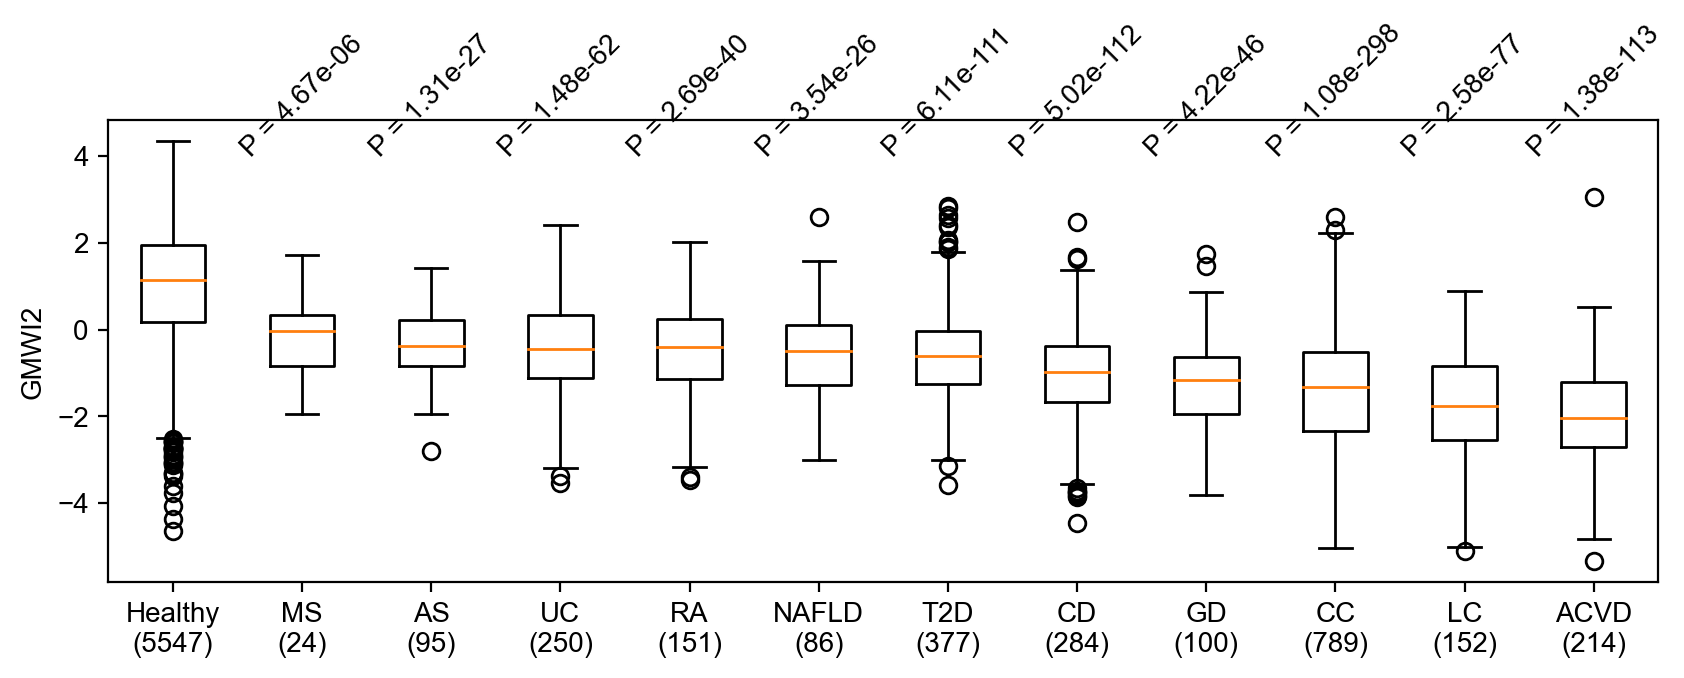

In [45]:
plt.figure(figsize =(10, 3), dpi=200)

labels = [phenotype_to_label[p] + f"\n({phenotype.iloc[phenotype.values == p].shape[0]})" for p in sorted_phenotypes]

plt.boxplot([scores[p] for p in sorted_phenotypes], labels=labels, showfliers=True)

for i, p in enumerate(sorted_phenotypes):
    if p == "Healthy" : continue
    pval = mannwhitneyu(scores["Healthy"], scores[p]).pvalue
    plt.text(i + 1, 4, "P = {0:.3g}".format(pval), horizontalalignment="center", rotation=45)

plt.ylabel("GMWI2")

plt.show()

## GMWI2 and GMWI healthy vs nonhealthy stratification (Fig. 1f and Supplementary table 1)

In [46]:
bins = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
healthy_prop = []
nonhealthy_prop = []
healthy_count = []
nonhealthy_count = []

for left, right in zip(bins, bins[1:]):
    bin_ = y.iloc[(GMWI2_scores.values.flatten() > left) & (GMWI2_scores.values.flatten() <= right)]
    healthy_prop.append(bin_.mean())
    nonhealthy_prop.append(1 - bin_.mean())
    
    healthy_count.append(bin_.sum())
    nonhealthy_count.append(bin_.shape[0] - bin_.sum())

In [47]:
def get_props(index_values):
    bins = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    healthy_prop = []
    nonhealthy_prop = []
    healthy_count = []
    nonhealthy_count = []

    for left, right in zip(bins, bins[1:]):
        bin_ = y.iloc[(index_values.values.flatten() > left) & (index_values.values.flatten() <= right)]
        healthy_prop.append(bin_.mean())
        nonhealthy_prop.append(1 - bin_.mean())

        healthy_count.append(bin_.sum())
        nonhealthy_count.append(bin_.shape[0] - bin_.sum())
    return healthy_prop, nonhealthy_prop, healthy_count, nonhealthy_count

In [48]:
gmwi2_healthy_prop, gmwi2_nonhealthy_prop, gmwi2_healthy_count, gmwi2_nonhealthy_count = get_props(GMWI2_scores)
gmwi_healthy_prop, gmwi_nonhealthy_prop, gmwi_healthy_count, gmwi_nonhealthy_count = get_props(GMWI_scores)

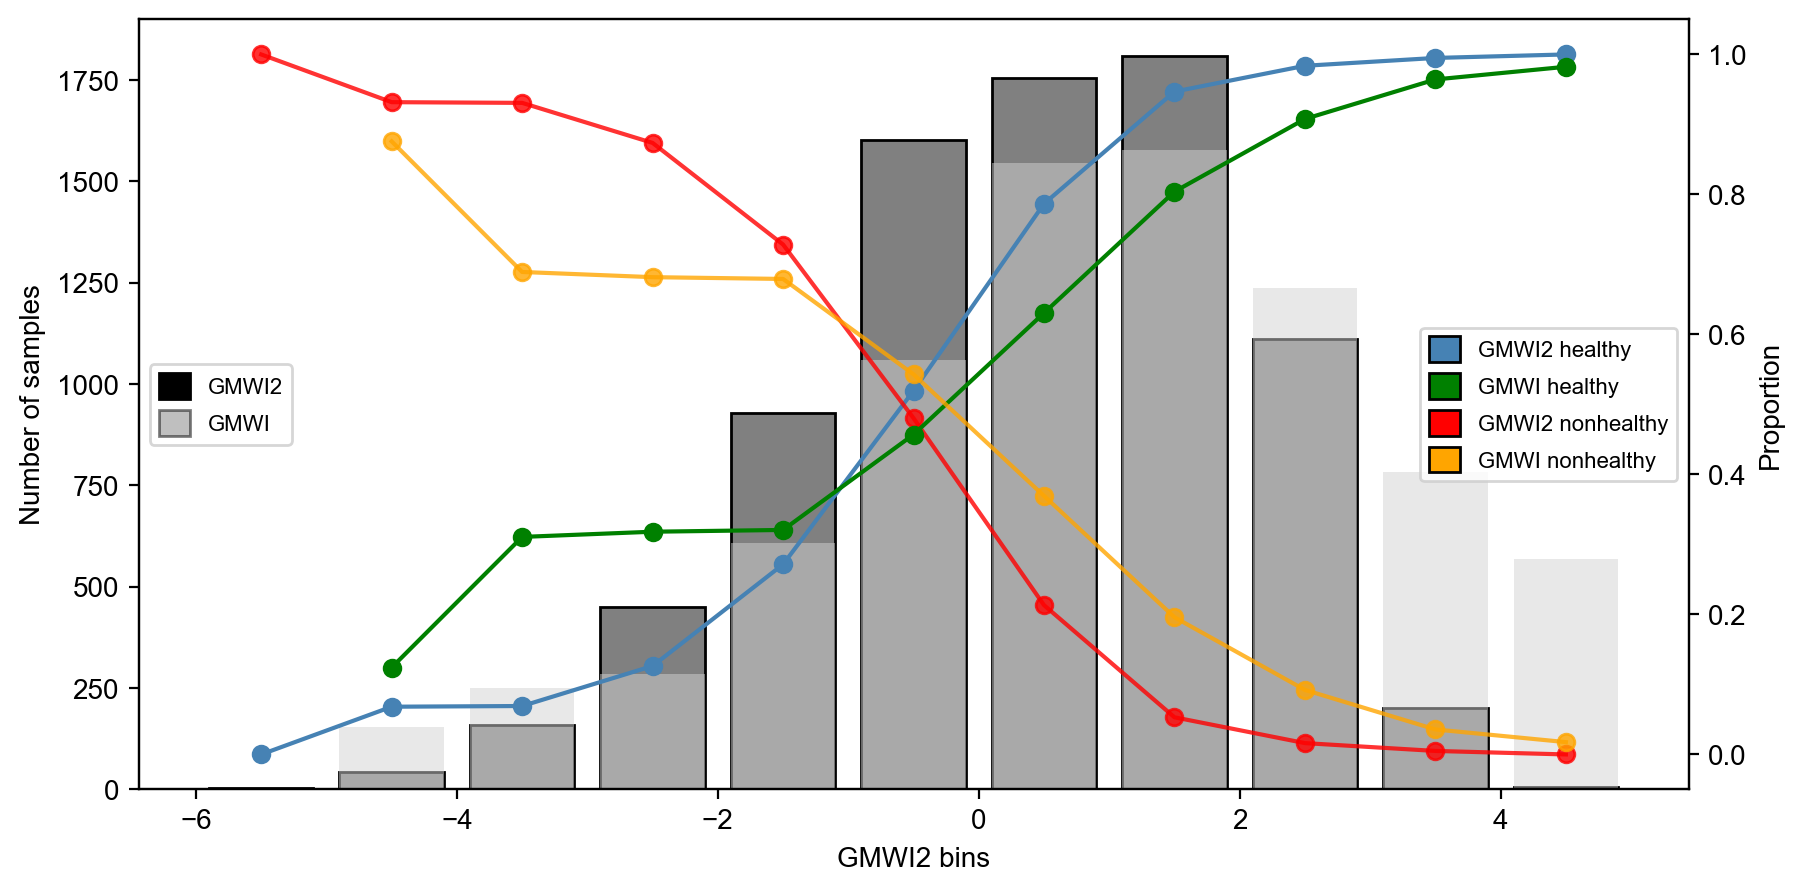

In [49]:
plt.figure(figsize=(10, 5), dpi=200)
ax = plt.gca()

rwidth = 0.8
ax.hist(GMWI2_scores, bins=bins, edgecolor = "black", color="gray", label="GMWI2", rwidth=rwidth)
ax.hist(GMWI_scores, bins=bins, color="lightgray", label="GMWI", alpha=0.5, rwidth=rwidth)

ax.set_ylabel("Number of samples")
ax.set_xlabel("GMWI2 bins")

ax_new = ax.twinx()

plot_locations = np.array(bins[:-1]) + 0.5

#gmwi2
ax_new.plot(plot_locations, gmwi2_healthy_prop, "o-", color="steelblue")
ax_new.plot(plot_locations, gmwi2_nonhealthy_prop, "o-", color="red", alpha=0.8)

#gmwi
ax_new.plot(plot_locations, gmwi_healthy_prop, "o-", color="green")
ax_new.plot(plot_locations, gmwi_nonhealthy_prop, "o-", color="orange", alpha=0.8)

ax_new.set_ylabel("Proportion")

handles = [
    Patch(facecolor="black", edgecolor="k", label="GMWI2"),
    Patch(facecolor="gray", edgecolor="k", label="GMWI", alpha=0.5),
]

ax.legend(handles=handles, prop={'size': 8}, loc=6, handlelength=1.4, handleheight=1.4)

handles = [
    Patch(facecolor="steelblue", edgecolor="k", label="GMWI2 healthy"),
    Patch(facecolor="green", edgecolor="k", label="GMWI healthy"),
    Patch(facecolor="red", edgecolor="k", label="GMWI2 nonhealthy"),
    Patch(facecolor="orange", edgecolor="k", label="GMWI nonhealthy"),
]

ax_new.legend(handles=handles, prop={'size': 8}, loc=0, handlelength=1.4, handleheight=1.4)

plt.show()

In [50]:
sample_info = pd.DataFrame()
sample_info["Bin range"] = [f"({l}, {r}]" for l, r in zip(bins, bins[1:])]
sample_info["GMWI2: Number of healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi2_healthy_count, gmwi2_healthy_prop)]
sample_info["GMWI2: Number of non-healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi2_nonhealthy_count, gmwi2_nonhealthy_prop)]
sample_info["GMWI: Number of healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi_healthy_count, gmwi_healthy_prop)]
sample_info["GMWI: Number of non-healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi_nonhealthy_count, gmwi_nonhealthy_prop)]
sample_info

Bin range  \
0   (-6, -5]   
1   (-5, -4]   
2   (-4, -3]   
3   (-3, -2]   
4   (-2, -1]   
5    (-1, 0]   
6     (0, 1]   
7     (1, 2]   
8     (2, 3]   
9     (3, 4]   
10    (4, 5]   

   GMWI2: Number of healthy samples in bin (proportion of total in bin)  \
0                                            0 (0.0%)                     
1                                            3 (6.8%)                     
2                                           11 (6.9%)                     
3                                          57 (12.6%)                     
4                                         252 (27.2%)                     
5                                         833 (52.0%)                     
6                                        1380 (78.7%)                     
7                                        1713 (94.7%)                     
8                                        1094 (98.4%)                     
9                                         199 (99.5%)                     
10                                         5 (100.0%)                     

   GMWI2: Number of non-healthy samples in bin (proportion of total in bin)  \
0                                          4 (100.0%)                         
1                                          41 (93.2%)                         
2                                         148 (93.1%)                         
3                                         394 (87.4%)                         
4                                         676 (72.8%)                         
5                                         770 (48.0%)                         
6                                         374 (21.3%)                         
7                                           96 (5.3%)                         
8                                           18 (1.6%)                         
9                                            1 (0.5%)                         
10                                           0 (0.0%)                         

   GMWI: Number of healthy samples in bin (proportion of total in bin)  \
0                                            0 (nan%)                    
1                                          19 (12.4%)                    
2                                          78 (31.1%)                    
3                                          91 (31.8%)                    
4                                         195 (32.1%)                    
5                                         484 (45.7%)                    
6                                         975 (63.1%)                    
7                                        1268 (80.4%)                    
8                                        1123 (90.8%)                    
9                                         756 (96.4%)                    
10                                        558 (98.2%)                    

   GMWI: Number of non-healthy samples in bin (proportion of total in bin)  
0                                            0 (nan%)                       
1                                         134 (87.6%)                       
2                                         173 (68.9%)                       
3                                         195 (68.2%)                       
4                                         413 (67.9%)                       
5                                         575 (54.3%)                       
6                                         571 (36.9%)                       
7                                         309 (19.6%)                       
8                                          114 (9.2%)                       
9                                           28 (3.6%)                       
10                                          10 (1.8%)

## Performance vs cutoff (Fig. 1g and Supplementary table 2)

In [51]:
def get_cutoff_performance_df(scores, max_cutoff, interval=0.1):
    dict_list = []
    for cutoff in np.arange(0, max_cutoff + interval, interval):
        idx = (abs(scores) >= cutoff).values
        samples_retained = float(idx.sum())
        bal_acc = balanced_accuracy_score(y[idx], scores[idx] > 0)
        dict_list.append({
            "cutoff" : cutoff,
            "samples retained" : samples_retained,
            "bal_acc" : bal_acc
        })
    df = pd.DataFrame(dict_list)
    return df

def plot_performance_vs_cutoff(scores, max_cutoff, left_y_label):
    df = get_cutoff_performance_df(scores, max_cutoff)
    display(df)
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=200)

    ax2 = ax1.twinx()
    ax1.plot(df["cutoff"], df["bal_acc"], c="steelblue")
    ax2.plot(df["cutoff"], df["samples retained"], c="orange")

    ax1.set_axisbelow(True)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax1.grid(linestyle = '--', linewidth = 0.75)

    ax1.tick_params(axis="both", labelsize=15)
    ax2.tick_params(axis="both", labelsize=15)

    samples_range = df["samples retained"].max() - df["samples retained"].min()
    acc_range = df["bal_acc"].max() - df["bal_acc"].min()
    
    yticks = [df["samples retained"].min() + (t - df["bal_acc"].min()) * samples_range / acc_range for t in ax1.get_yticks()[1:-1]]
    
    ax2.set_yticks(yticks)

    ax1.set_ylabel(left_y_label, fontsize=15)
    ax2.set_ylabel("Samples retained", fontsize=15)
    ax1.set_xlabel("GMWI2 Magnitude Cutoff", fontsize=15)
    plt.show()

cutoff  samples retained   bal_acc
0      0.0            8069.0  0.798853
1      0.1            7719.0  0.811917
2      0.2            7333.0  0.824876
3      0.3            7004.0  0.835330
4      0.4            6691.0  0.846499
5      0.5            6364.0  0.857515
6      0.6            6029.0  0.870530
7      0.7            5664.0  0.882040
8      0.8            5365.0  0.891837
9      0.9            5049.0  0.901703
10     1.0            4712.0  0.909833
11     1.1            4412.0  0.916332
12     1.2            4087.0  0.925931
13     1.3            3782.0  0.933496
14     1.4            3521.0  0.938937
15     1.5            3238.0  0.945615
16     1.6            2943.0  0.947230
17     1.7            2697.0  0.949973
18     1.8            2451.0  0.955112
19     1.9            2210.0  0.955345
20     2.0            1975.0  0.958392
21     2.1            1756.0  0.960739
22     2.2            1545.0  0.959675
23     2.3            1347.0  0.961033
24     2.4            1168.0  0.962111
25     2.5             998.0  0.964504
26     2.6             843.0  0.967282
27     2.7             719.0  0.964982
28     2.8             589.0  0.968428
29     2.9             507.0  0.968111
30     3.0             412.0  0.965313

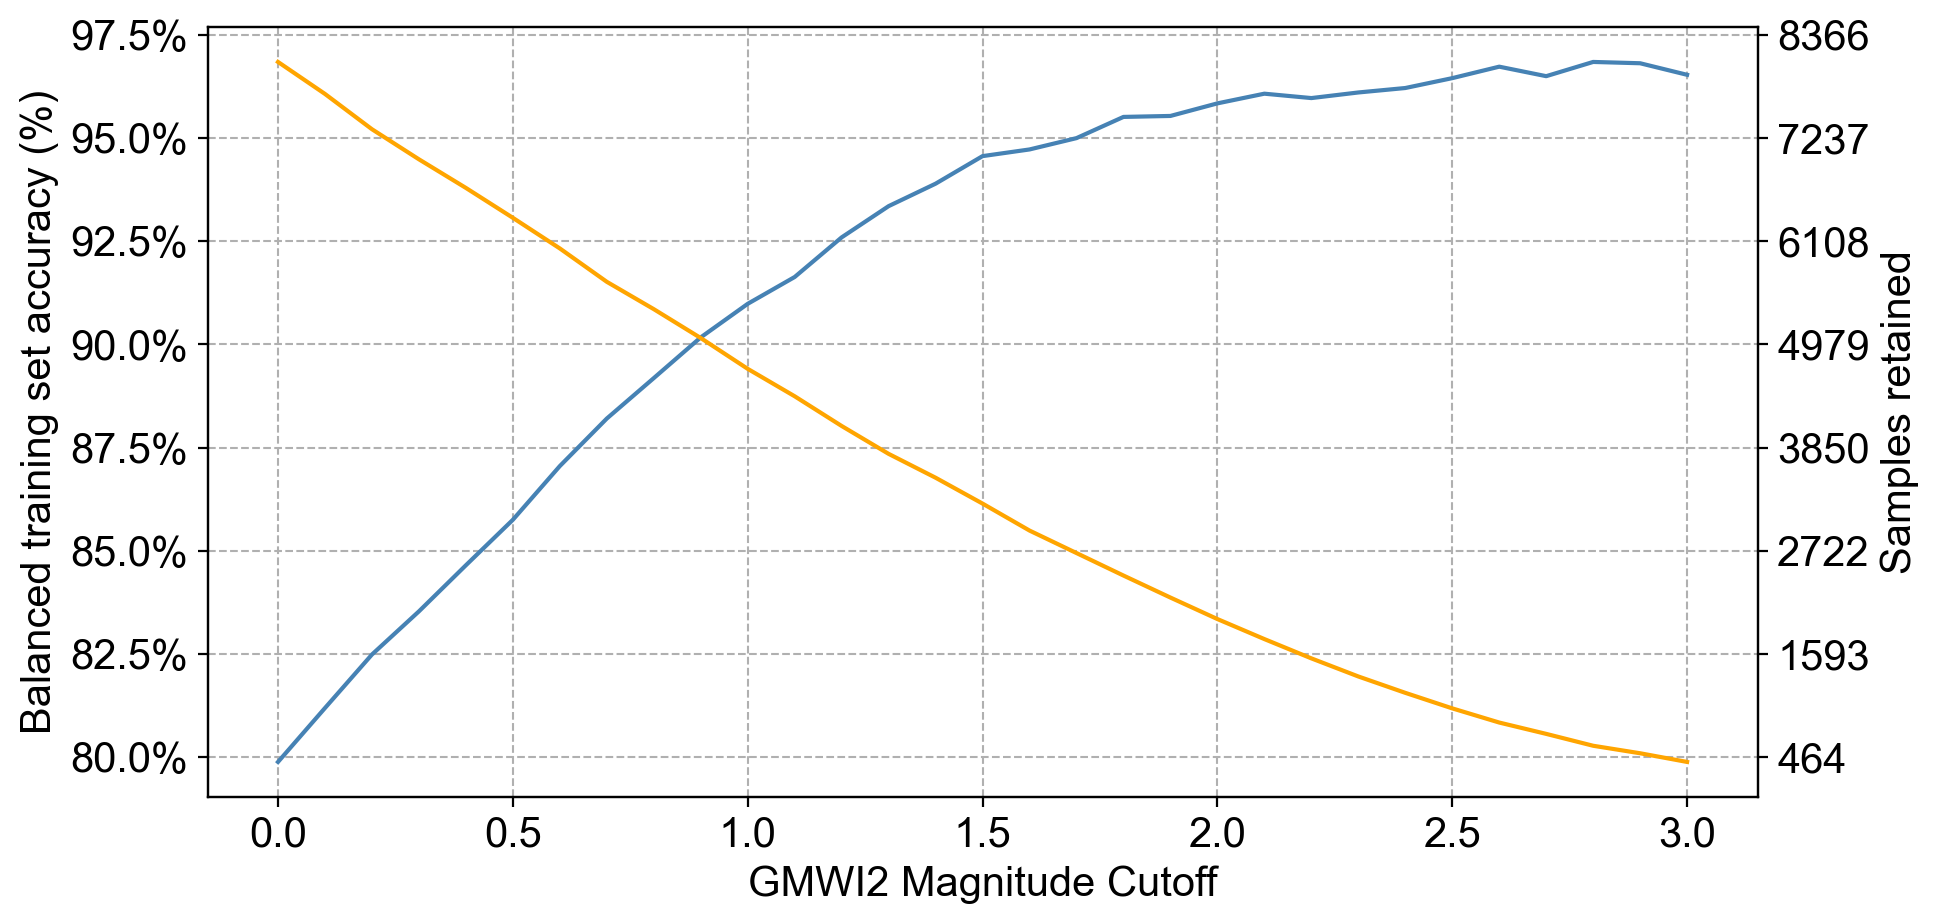

In [52]:
plot_performance_vs_cutoff(GMWI2_scores, 3, "Balanced training set accuracy (%)")

## Compute 10-fold and LOOCV logit predictions

In [53]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=np.random.randint(0, high=1000000))

# instantiate the logistic regression classifier (gmhi2)
gmwi2_kfold = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")

# generate logit predictions in 10 fold cross validation
GMWI2_scores_kfold = cross_val_predict(gmwi2_kfold, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
    cv=kfold, verbose=2, n_jobs=-1
)

GMWI2_scores_kfold = pd.DataFrame(GMWI2_scores_kfold, index=y.index, columns=["GMHI2_kfold"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    5.9s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished


In [419]:
leave = LeaveOneOut()
    
# instantiate the logistic regression classifier (gmhi2)
gmwi2_loo = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")

# generate logit predictions in LOOCV
GMWI2_scores_loo = cross_val_predict(gmwi2_loo, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
    cv=leave, verbose=2, n_jobs=-1
)

GMWI2_scores_loo = pd.DataFrame(GMWI2_scores_loo, index=y.index, columns=["GMWI2_loo"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 8069 out of 8069 |

## Performance vs cutoff for all cv methods (Fig. 1h)

In [56]:
perf_cutoff_all = []

for cutoff in [0, 0.5, 1]:
    for index, score in [
        ("GMWI training", GMWI_scores), 
        ("GMWI2 training", GMWI2_scores),
        ("GMWI2 LOOCV", GMWI2_scores_loo),
        ("GMWI2 10-fold", GMWI2_scores_kfold),
    ]:
        keep = score.iloc[:, 0].abs() > cutoff
        curr_y = y[keep].iloc[:, 0]
        score = score[keep].iloc[:, 0]
        pred = score > 0
        balanced = balanced_accuracy_score(curr_y, pred)
        healthy = float((pred & curr_y).sum() / curr_y.sum())
        nonhealthy = float((~pred & ~curr_y).sum() / (~curr_y).sum())
        
        perf_cutoff_all.append({
            "cutoff" : cutoff,
            "index" : index,
            "healthy" : healthy,
            "non-healthy" : nonhealthy,
            "balanced accuracy" : balanced,
        })
        
perf_df = pd.DataFrame(perf_cutoff_all)
perf_df

cutoff           index   healthy  non-healthy  balanced accuracy
0      0.0   GMWI training  0.843699     0.590801           0.717250
1      0.0  GMWI2 training  0.791599     0.806106           0.798853
2      0.0     GMWI2 LOOCV  0.786371     0.795004           0.790687
3      0.0   GMWI2 10-fold  0.784929     0.789056           0.786993
4      0.5   GMWI training  0.880419     0.618277           0.749348
5      0.5  GMWI2 training  0.850972     0.864058           0.857515
6      0.5     GMWI2 LOOCV  0.846955     0.852062           0.849508
7      0.5   GMWI2 10-fold  0.847461     0.851640           0.849551
8      1.0   GMWI training  0.906311     0.664971           0.785641
9      1.0  GMWI2 training  0.903119     0.916546           0.909833
10     1.0     GMWI2 LOOCV  0.898981     0.908096           0.903539
11     1.0   GMWI2 10-fold  0.897779     0.903917           0.900848

## GMWI2 ISV performance (Fig. 2a and Supplementary Table 3)

In [57]:
# indentify groups to partition dataset
sample_studies = np.array(X.index.get_level_values(0))
o = OrdinalEncoder()
groups = o.fit_transform(sample_studies.reshape((len(sample_studies), 1))).flatten()
logo = LeaveOneGroupOut()

gmwi2_ISV = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")

# generate logit predictions for each left out study
GMWI2_scores_ISV = cross_val_predict(gmwi2_ISV, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
    groups=groups, cv=logo, verbose=-1, n_jobs=-1
)

bal = balanced_accuracy_score(y, GMWI2_scores_ISV > 0)
bal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   12.2s finished


0.7575933194057787

In [58]:
GMWI2_scores_ISV = pd.DataFrame(GMWI2_scores_ISV, index=X.index)

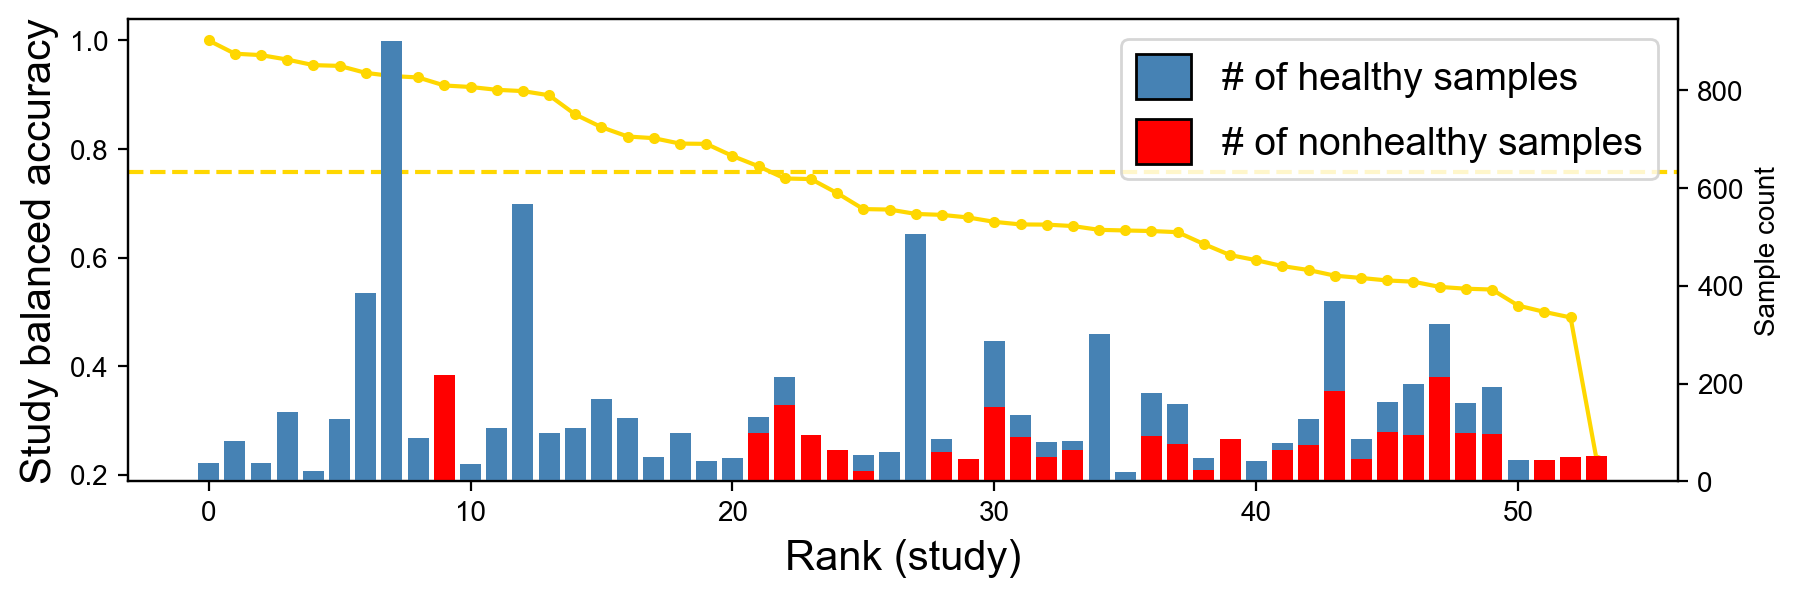

In [59]:
def plot_study_scores(index_scores, y):
    
    plt.figure(figsize=(10, 3), dpi=200)
    ax = plt.gca()
    
    studies = np.unique(index_scores.index.get_level_values(0))
    
    study_performances = {s : balanced_accuracy_score(y.loc[s], index_scores.loc[s] > 0) for s in studies}
    num_healthy = {s : int(y.loc[s].sum()) for s in studies}
    num_nonhealthy = {s : len(y.loc[s]) - int(y.loc[s].sum()) for s in studies}
    
    sorted_studies = sorted(studies, key=lambda x : study_performances[x], reverse=True)
    
    ax.plot([study_performances[s] for s in sorted_studies], ".-", color="gold")
    
    ax_new = ax.twinx()
    
    nonhealthy_counts = [num_nonhealthy[s] for s in sorted_studies]
    healthy_counts = [num_healthy[s] for s in sorted_studies]
    
    ax_new.bar(np.arange(len(studies)), nonhealthy_counts, color="red")
    ax_new.bar(np.arange(len(studies)), healthy_counts, bottom=nonhealthy_counts, color="steelblue")
    ax_new.set_ylabel("Sample count")
    
    ax.set_xlabel("Rank (study)", fontsize=15)
    ax.set_ylabel("Study balanced accuracy", fontsize=15)
    
    handles = [
        Patch(facecolor="steelblue", edgecolor="k", label="# of healthy samples"),
        Patch(facecolor="red", edgecolor="k", label="# of nonhealthy samples"),
    ]

    plt.legend(handles=handles, prop={'size': 14}, loc=0, handlelength=1.4, handleheight=1.4)
    
    ax.axline((0, bal), slope=0, c='gold', linestyle="--")
    
    plt.show()
    
plot_study_scores(pd.DataFrame(GMWI2_scores_ISV, index=X.index), y)

In [60]:
studies = np.unique(GMWI2_scores_ISV.index.get_level_values(0))

study_performances = {s : balanced_accuracy_score(y.loc[s], GMWI2_scores_ISV.loc[s] > 0) for s in studies}
num_healthy = {s : int(y.loc[s].sum()) for s in studies}
num_nonhealthy = {s : len(y.loc[s]) - int(y.loc[s].sum()) for s in studies}

sorted_studies = sorted(studies, key=lambda x : study_performances[x], reverse=True)

In [61]:
study_performance_df = pd.DataFrame([[study_performances[s], num_healthy[s], num_nonhealthy[s]] for s in sorted_studies], 
             columns=["balanced accuracy", "num healthy", "num nonhealthy"], index=sorted_studies)
study_performance_df

balanced accuracy  \
Smits (2017)                                                 1.000000   
Jacobson (2021)                                              0.975610   
Lokmer (2019)                                                0.972973   
Pasolli (2019)                                               0.964789   
Ang (2021)                                                   0.954545   
D’Souza (2021)                                               0.953125   
Schirmer (2016)                                              0.940260   
Zeevi (2015)                                                 0.934444   
Le Chatelier (2013)                                          0.931818   
Yachida (2019)                                               0.917051   
Rettedal (2021)                                              0.914286   
Tett (2019)                                                  0.909091   
Asnicar (2021)                                               0.906690   
De Filippis (2019)                                           0.898990   
Liu (2016)                                                   0.863636   
Costea (2017)                                                0.840237   
Xie (2016)                                                   0.823077   
Roager (2019)                                                0.820000   
Backhed (2015)                                               0.810000   
Yassour (2018)                                               0.809524   
Dhakan (2019)                                                0.787234   
Zhu (2021)                                                   0.768125   
Franzosa (2018)                                              0.745735   
Gu (2017)                                                    0.744681   
Ananthakrishnan (2017)                                       0.718750   
Wirbel (2019)                                                0.689394   
Kim (2021)                                                   0.688525   
HMP1 (Phase-I): Structure, function and diversi...           0.680473   
Lloyd-Price (2019)                                           0.678689   
Feng (2015)                                                  0.673913   
Qin (2014)                                                   0.665887   
Zeller (2014)                                                0.661111   
Vogtmann (2016)                                              0.660784   
Schirmer (2018)                                              0.658120   
Mehta (2018)                                                 0.651163   
Obregon-Tito (2015)                                          0.650000   
Yang (2020)                                                  0.648962   
Nielsen (2014)                                               0.646817   
Ventura (2019)                                               0.625000   
Loomba (2017)                                                0.604651   
Sun (2021)                                                   0.595238   
Weng (2019)                                                  0.584375   
Yu (2015)                                                    0.577107   
Qin (2012)                                                   0.566764   
He (2017)                                                    0.562500   
Zhang (2015)                                                 0.557940   
Wen (2017)                                                   0.555639   
Jie (2017)                                                   0.546080   
Thomas (2019)                                                0.542722   
Yang (2021)                                                  0.541237   
Qi (2019)                                                    0.511628   
Davies (2020)                                                0.500000   
Gupta (2020)                                                 0.489796   
Karlsson (2013)                                              0.226415   

                                    

## ROC curve (Fig. 2b)

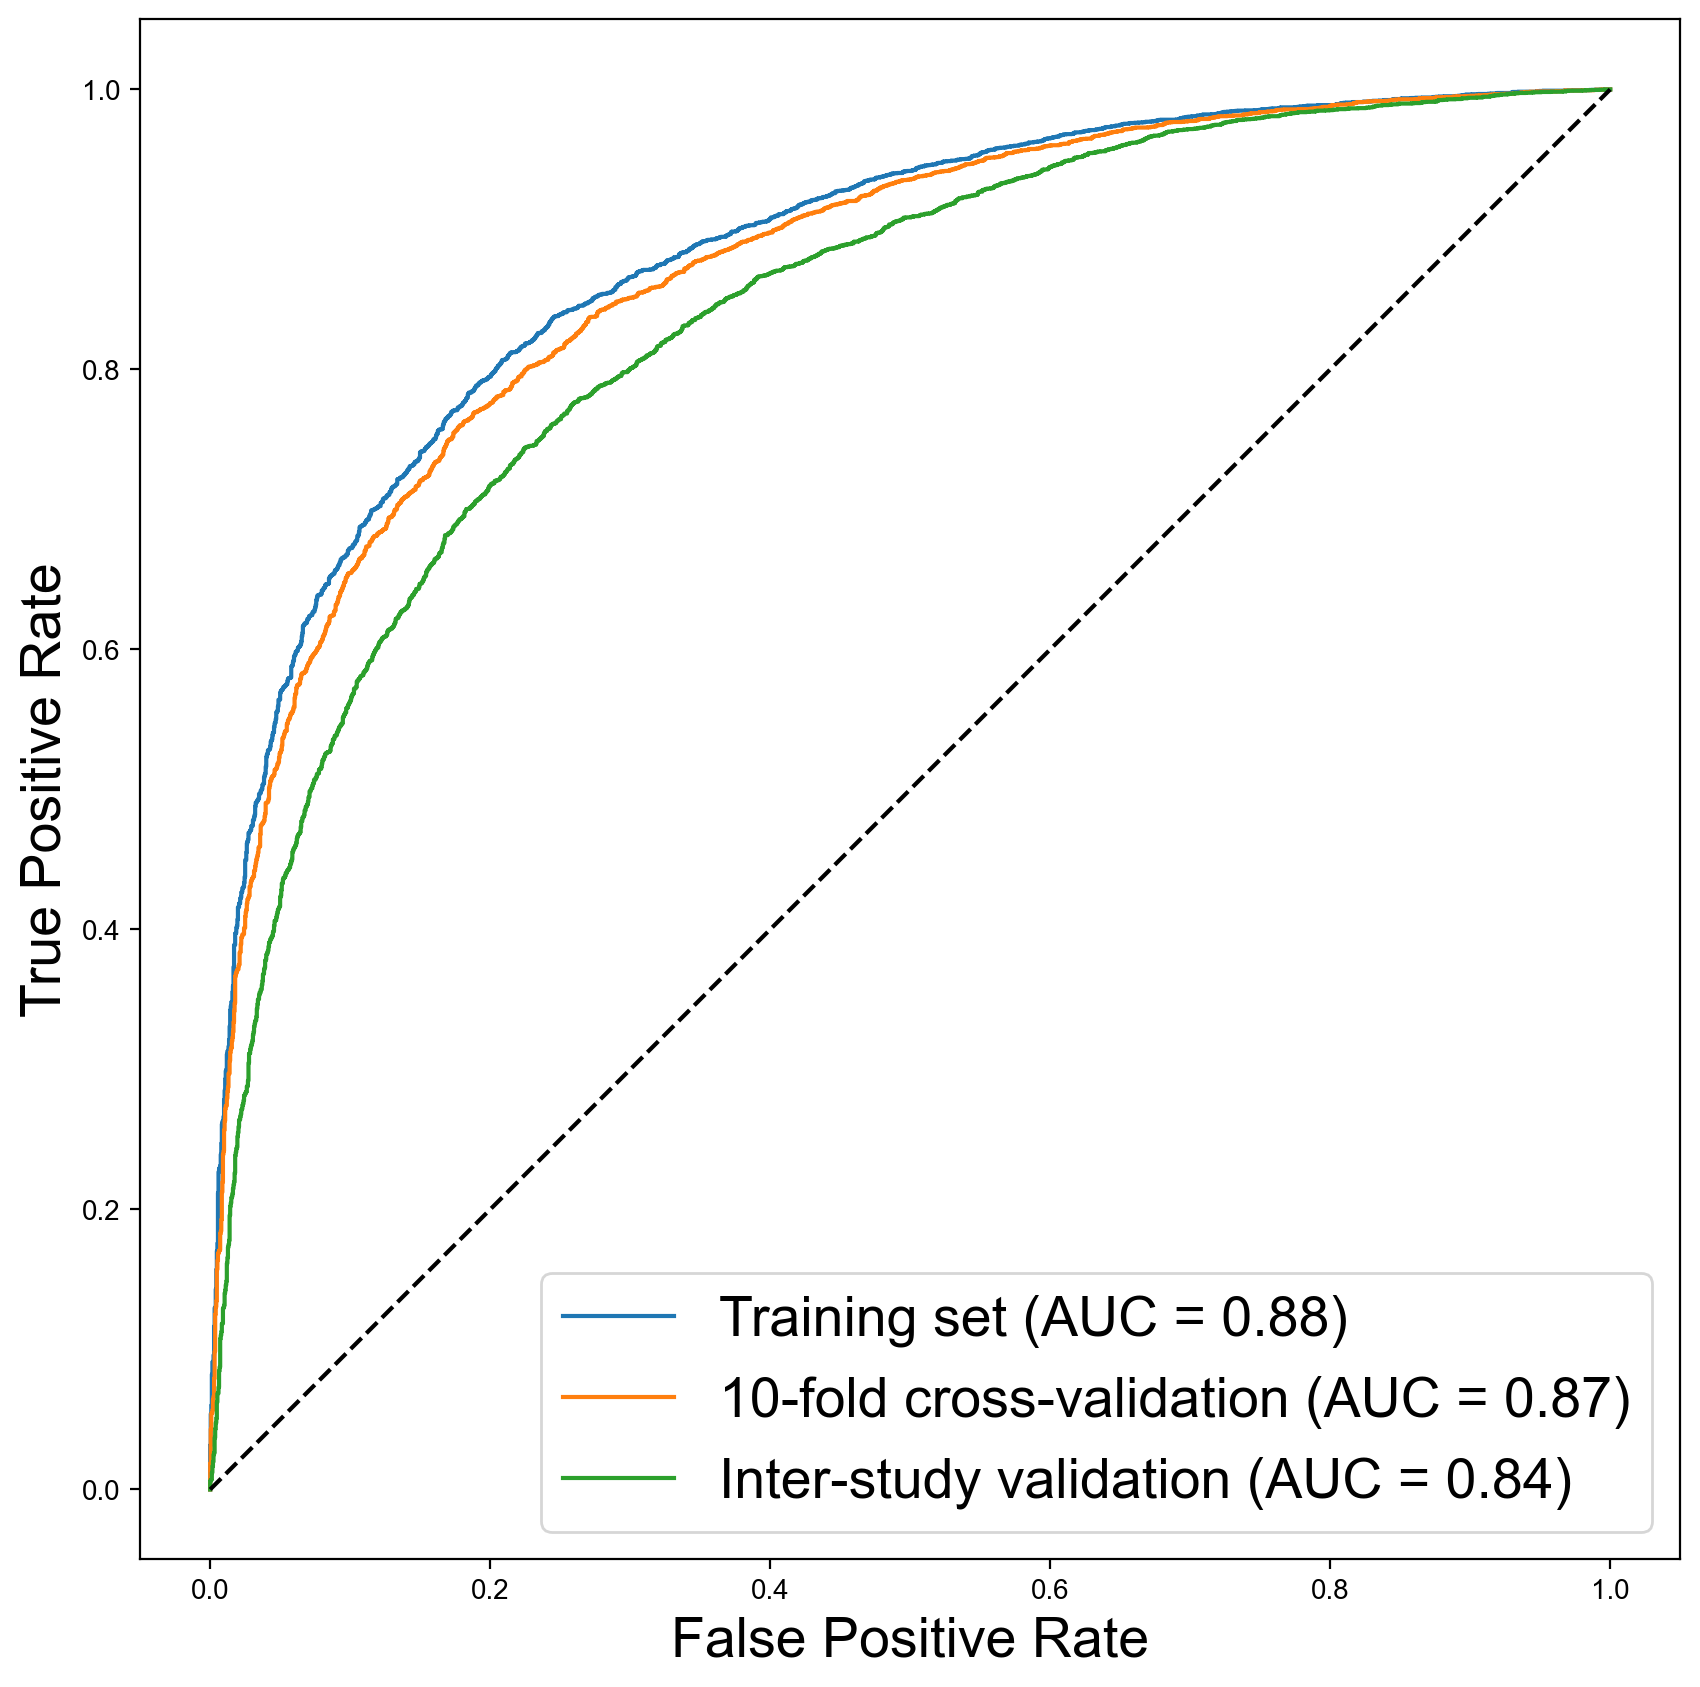

In [62]:
plt.figure(figsize=(10, 10), dpi=200)
ax = plt.gca()
RocCurveDisplay.from_predictions(y, GMWI2_scores, ax=ax, name="Training set")
RocCurveDisplay.from_predictions(y, GMWI2_scores_kfold, ax=ax, name="10-fold cross-validation")
RocCurveDisplay.from_predictions(y, GMWI2_scores_ISV, ax=ax, name="Inter-study validation")

plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.legend(fontsize=20)

# Apply GMWI2 to longitudinal case studies

In [565]:
def unpack_longitudinal_df(longitudinal_df):
    taxa = longitudinal_df[[c for c in longitudinal_df.columns if c.startswith("k__") or c.startswith("UNK")]]
    meta = longitudinal_df[["Subject_ID", "health_status/host_diet", "timepoint"]]
    return taxa, meta

In [566]:
def get_diversity(meta, X):
    X_species = X[[col for col in X.columns if "s__" in col and "virus" not in col and "unclassified" not in col]]
    meta = meta.copy()
    meta["Species Richness"] = np.sum(X_species > PRESENCE_CUTOFF, axis=1).values
    meta["Shannon Diversity"] = np.sum(-1 * (X_species * np.log(X_species)).fillna(0).values, axis=1)
    meta["Simpson Diversity"] = np.sum((X_species ** 2).values, axis=1)
    return meta

In [567]:
def compute_indices(meta, X):
    meta = get_diversity(meta.copy(), X)
    meta["GMWI2"] = gmwi2.decision_function(X > PRESENCE_CUTOFF)
    return meta

In [695]:
def plot_longitudinal(meta, indices, timepoints_sorted, stars=False, show_tau=False, alternative="two-sided"):
    """
    meta is a df that has columns: ["timepoint", "timepoint_plot", index]
    """
    fig, axs = plt.subplots(ncols=len(indices), figsize=(10 * len(indices), 6), dpi=200)
    for index, ax in zip(indices, axs):
        # plot each subject's longitudinal line
        subjects = np.unique(meta.index)
        for subject in subjects:
            df = meta.loc[[subject]].copy()
            df = df.sort_values("timepoint_plot")
            ax.plot(df["timepoint_plot"], df[index], c="#c2b59b", zorder=0, linewidth=2)
        ax.set_ylabel(index, fontsize=18)
        ax.set_xlabel("Time point", fontsize=18)
        
        colors = ["#a285b8", "#bdb8d9", "#cce6c4", "#fcf6b5", "#fbb462", "#f9cee1", "#f47f71"]
        
        # scatter and boxplot
        for i, time in enumerate(timepoints_sorted):
            pos = i
            data = meta[meta["timepoint"] == time][index]
            sc = ax.scatter(np.ones(data.shape[0]) * pos, data, c="white", edgecolor="k", zorder=3)
            c = colors[i]
            width = 1.0
            bp = ax.boxplot(data, positions=[pos], patch_artist=True, widths=[0.5],
                boxprops=dict(facecolor=c, color="k", linewidth=width, alpha=0.5),
                capprops=dict(color="k", linewidth=0),
                whiskerprops=dict(color="k", linewidth=width),
                flierprops=dict(color="k", markeredgecolor="k", linewidth=width),
                medianprops=dict(color="#7e2718", linewidth=3),
                            )

        ran = meta[index].max() - meta[index].min()

        y = meta[index].max() + ran * 0.05
        y2 = meta[index].max() + ran * 0.1

        baseline = timepoints_sorted[0]
        baseline_df = meta[meta["timepoint"] == baseline]
        for i, timepoint in enumerate(timepoints_sorted):
            if timepoint == timepoints_sorted[0]: continue
            if timepoint == meta["timepoint"].min(): continue
            display(meta)
            timepoint_df = meta[meta["timepoint"] == timepoint]
            subjects_in_both = set(baseline_df.index) & set(timepoint_df.index)
            timepoint_df = timepoint_df.loc[subjects_in_both]
            baseline_df_curr = baseline_df.loc[subjects_in_both]
            if timepoint_df.shape[0] == 0 or baseline_df_curr.shape[0] == 0:
                wilcoxon_p = 1
                tau_p = 1
            else:
                stat = wilcoxon(baseline_df_curr[index], timepoint_df[index], alternative=alternative)
                wilcoxon_p = stat.pvalue
                stat = kendalltau(baseline_df_curr[index], timepoint_df[index])
                tau, tau_p = stat
                
            x = i
            
            if stars:
                text = "****" if wilcoxon_p <= 0.0001 else "***" if wilcoxon_p <= 0.001 else "**" if wilcoxon_p <= 0.01 else "*" if wilcoxon_p <= 0.05 else "n.s."
            else:
                text = "$P = " + '%.2g' % wilcoxon_p + "$" if wilcoxon_p < 0.05 else "n.s."
#                 text = "$P = " + '%.2g' % wilcoxon_p + "$"
            ax.text(x, y, text, ha="center", fontsize=12)
            
            if show_tau and tau_p < 0.05:
                ax.text(x, y2, r"$\tau$ = " + '%.2g' % tau, ha="center", fontsize=14)

        ax.set_xticks(ticks=list(range(len(timepoints_sorted))))
        
        ax.set_xticklabels(labels=[t + f"\n(n={meta[meta['timepoint'] == str(t)].shape[0]})" for t in timepoints_sorted], fontsize=14)
        
        ax.tick_params(axis="y", labelsize=14)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom, ran * 0.05 + (y2 if show_tau else y))
        ax.grid(axis="y", linestyle="--", dashes=(5, 5))

## Goll *et al.* 2020 (FMT, Fig. 2c, Supplementary Fig. 2 and 3, Supplementary Table 4)

In [682]:
goll = longitudinal_cases.loc["Goll (2020)"]

In [683]:
goll_X, goll_meta = unpack_longitudinal_df(goll)
display(goll_X.head(), goll_meta.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Sample Accession                                            
SAMEA7082416        0.011792                     0.011792   
SAMEA7082415        0.000290                     0.000290   
SAMEA7082414        0.005431                     0.005431   
SAMEA7082413        0.002655                     0.002655   
SAMEA7082412        0.000000                     0.000000   

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Sample Accession                                                   
SAMEA7082416                                            0.011792   
SAMEA7082415                                            0.000290   
SAMEA7082414                                            0.005431   
SAMEA7082413                                            0.002655   
SAMEA7082412                                            0.000000   

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Sample Accession                                                                         
SAMEA7082416                                               0.011792                      
SAMEA7082415                                               0.000290                      
SAMEA7082414                                               0.005431                      
SAMEA7082413                                               0.002655                      
SAMEA7082412                                               0.000000                      

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Sample Accession                                                                                                
SAMEA7082416                                               0.011792                                             
SAMEA7082415                                               0.000290                                             
SAMEA7082414                                               0.005431                                             
SAMEA7082413                                               0.002655                                             
SAMEA7082412                                               0.000000                                             

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Sample Accession                                                                                                                      
SAMEA7082416                                               0.011792                                                                   
SAMEA7082415                                               0.000290                                                                   
SAMEA7082414                                               0.005431                                                                   
SAMEA7082413                                               0.002655                                                                   
SAMEA7082412                                               0.000000                                                                   

                  k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Sample Accession                                                                                                                                                    
SAMEA7082416                                               0.011792                                                                                                 
SAMEA7082415                                               0.000290                                                                                                 
SAMEA7082414                                               0.005431                 

Subject_ID health_status/host_diet timepoint
Sample Accession                                             
SAMEA7082416             90                  effect         6
SAMEA7082415             90                  effect        12
SAMEA7082414             90                  effect         0
SAMEA7082413             89                  effect         6
SAMEA7082412             89                  effect        12

In [684]:
goll_meta = compute_indices(goll_meta, goll_X)
goll_meta

Subject_ID health_status/host_diet timepoint  \
Sample Accession                                                   
SAMEA7082416                90                  effect         6   
SAMEA7082415                90                  effect        12   
SAMEA7082414                90                  effect         0   
SAMEA7082413                89                  effect         6   
SAMEA7082412                89                  effect        12   
...                        ...                     ...       ...   
SAMEA7082429       D-6Fresk_S5                 Healthy       NaN   
SAMEA7082430       D-6Fryst_S4                 Healthy       NaN   
SAMEA7082431       D-7Fryst_S7                 Healthy       NaN   
SAMEA7082432      D-9Feresk_S9                 Healthy       NaN   
SAMEA7082433       D-9Fryst_S2                 Healthy       NaN   

                  Species Richness  Shannon Diversity  Simpson Diversity  \
Sample Accession                                                           
SAMEA7082416                    70           2.957032           0.070021   
SAMEA7082415                    81           2.877896           0.083205   
SAMEA7082414                    68           2.611362           0.108119   
SAMEA7082413                    89           2.902013           0.052669   
SAMEA7082412                    65           2.572868           0.107847   
...                            ...                ...                ...   
SAMEA7082429                    64           3.021262           0.063898   
SAMEA7082430                    54           2.749086           0.086027   
SAMEA7082431                    70           2.420487           0.161644   
SAMEA7082432                    50           1.747606           0.337830   
SAMEA7082433                    63           2.731925           0.089670   

                     GMWI2  
Sample Accession            
SAMEA7082416      2.361107  
SAMEA7082415      1.468948  
SAMEA7082414      1.219487  
SAMEA7082413      0.583346  
SAMEA7082412      2.263538  
...                    ...  
SAMEA7082429      0.863733  
SAMEA7082430      1.102286  
SAMEA7082431      1.355348  
SAMEA7082432      0.240047  
SAMEA7082433      0.658469  

[83 rows x 7 columns]

In [685]:
goll_meta_donors = goll_meta[goll_meta["health_status/host_diet"] == "Healthy"]
goll_meta = goll_meta[goll_meta["health_status/host_diet"] != "Healthy"]

In [686]:
goll_meta["Subject_ID"] = goll_meta["Subject_ID"].astype(str)
goll_meta = goll_meta.set_index("Subject_ID")

In [687]:
goll_meta["timepoint_plot"] = [int(time) for time in goll_meta["timepoint"]]
goll_meta["timepoint_plot"] = goll_meta["timepoint_plot"].apply(lambda x : {0 : 0, 6 : 1, 12 : 2}[x])

In [688]:
timepoints_sorted = ["0", "6"]
indices = ["GMWI2", "Species Richness", "Shannon Diversity"]

In [689]:
goll_meta = goll_meta[goll_meta["timepoint"] != 12]
goll_meta["timepoint"] = goll_meta["timepoint"].astype(int).astype(str)

In [697]:
for group in goll_meta["health_status/host_diet"].unique():
    print(group)
    meta_curr = goll_meta.copy()
    display(meta_curr[meta_curr["health_status/host_diet"] == group])
    break
    plot_longitudinal(meta_curr[meta_curr["health_status/host_diet"] == group], indices, timepoints_sorted, stars=False, alternative="less")
    break
    

effect


health_status/host_diet timepoint  Species Richness  \
Subject_ID                                                       
90                          effect         6                70   
90                          effect         0                68   
89                          effect         6                89   
89                          effect         0                78   
88                          effect         6                76   
88                          effect         0                69   
78                          effect         6                80   
78                          effect         0                72   
77                          effect         6                76   
77                          effect         0                95   
59                          effect         6                73   
59                          effect         0                79   
31                          effect         6                90   
31                          effect         0                74   
30                          effect         6                82   
30                          effect         0                81   
3                           effect         6                70   
3                           effect         0                70   
25                          effect         6                92   
25                          effect         0                66   
24                          effect         6                83   
24                          effect         0                76   
19                          effect         6                77   
19                          effect         0                54   
16                          effect         6                82   
nan                         effect         0                59   
11                          effect         6                78   
11                          effect         0                81   

            Shannon Diversity  Simpson Diversity     GMWI2  timepoint_plot  
Subject_ID                                                                  
90                   2.957032           0.070021  2.361107               1  
90                   2.611362           0.108119  1.219487               0  
89                   2.902013           0.052669  0.583346               1  
89                   2.450486           0.112708 -0.535925               0  
88                   3.006696           0.082958  2.354115               1  
88                   2.700168           0.078924  2.242830               0  
78                   2.346084           0.184938  1.031209               1  
78                   1.844365           0.294692  1.480539               0  
77                   0.725859           0.001732  0.103116               1  
77                   2.932706           0.085432 -1.458950               0  
59                   2.936825           0.086600  1.359736               1  
59                   2.667012           0.080368 -0.133333               0  
31                   3.070873           0.059911  1.850342               1  
31                   2.857695           0.051869  2.153703               0  
30                   3.042173           0.068088  2.557795               1  
30                   2.824475           0.068170  1.878644               0  
3                    2.807719           0.084163  1.914169               1  
3                    2.728432           0.070920  1.971127               0  
25                   2.906117           0.092740  2.204800               1  
25                   2.910050           0.081560 -0.015805               0  
24                   2.809249           0.089528  2.391525               1  
24                   2.844070           0.083087  0.152719               0  
19                   2.814742           0.129631  0.170370               1  
19                   2.408141           0.091276  1.723070               0  
16                   2.81795

## Tanes *et al.* 2021 (Dietary fiber, Fig. 2d, Supplementary Fig. 4, Supplementary Table 5)

In [430]:
tanes = longitudinal_cases.loc[["Tanes (2021)"]]

In [431]:
tanes_X, tanes_meta = unpack_longitudinal_df(tanes)
display(tanes_X.head(), tanes_meta.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID     Sample Accession                                            
Tanes (2021) SAMN16701456             0.0                          0.0   
             SAMN16701455             0.0                          0.0   
             SAMN16701454             0.0                          0.0   
             SAMN16701453             0.0                          0.0   
             SAMN16701452             0.0                          0.0   

                               k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID     Sample Accession                                                   
Tanes (2021) SAMN16701456                                                 0.0   
             SAMN16701455                                                 0.0   
             SAMN16701454                                                 0.0   
             SAMN16701453                                                 0.0   
             SAMN16701452                                                 0.0   

                               k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID     Sample Accession                                                                         
Tanes (2021) SAMN16701456                                                    0.0                      
             SAMN16701455                                                    0.0                      
             SAMN16701454                                                    0.0                      
             SAMN16701453                                                    0.0                      
             SAMN16701452                                                    0.0                      

                               k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID     Sample Accession                                                                                                
Tanes (2021) SAMN16701456                                                    0.0                                             
             SAMN16701455                                                    0.0                                             
             SAMN16701454                                                    0.0                                             
             SAMN16701453                                                    0.0                                             
             SAMN16701452                                                    0.0                                             

                               k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID     Sample Accession                                                                                                                      
Tanes (2021) SAMN16701456                                                    0.0                                                                   
             SAMN16701455                                                    0.0                                                                   
             SAMN16701454                                                    0.0                                                                   
             SAMN16701453                                                    0.0                                                                   
             SAMN16701452                                                    0.0                                                                   

                               k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID     Sample Accession                                                                                               

Subject_ID health_status/host_diet timepoint
Study_ID     Sample Accession                                             
Tanes (2021) SAMN16701456           9016                     EEN        12
             SAMN16701455           9016                     EEN        11
             SAMN16701454           9016                     EEN        10
             SAMN16701453           9016                     EEN         9
             SAMN16701452           9016                     EEN         8

In [432]:
tanes_meta = compute_indices(tanes_meta, tanes_X)
tanes_meta

Subject_ID health_status/host_diet timepoint  \
Study_ID     Sample Accession                                                
Tanes (2021) SAMN16701456           9016                     EEN        12   
             SAMN16701455           9016                     EEN        11   
             SAMN16701454           9016                     EEN        10   
             SAMN16701453           9016                     EEN         9   
             SAMN16701452           9016                     EEN         8   
...                                  ...                     ...       ...   
             SAMN16701308           9003                     EEN         3   
             SAMN16701460           9017                   Vegan         1   
             SAMN16701459           9016                     EEN        15   
             SAMN16701458           9016                     EEN        14   
             SAMN16701457           9016                     EEN        13   

                               Species Richness  Shannon Diversity  \
Study_ID     Sample Accession                                        
Tanes (2021) SAMN16701456                    19           1.834157   
             SAMN16701455                    15           1.508526   
             SAMN16701454                    18           1.834897   
             SAMN16701453                     2           0.426438   
             SAMN16701452                     1           0.291104   
...                                         ...                ...   
             SAMN16701308                    54           2.075606   
             SAMN16701460                    52           2.556873   
             SAMN16701459                    16           1.507728   
             SAMN16701458                    18           1.408565   
             SAMN16701457                    12           0.900493   

                               Simpson Diversity     GMWI2  
Study_ID     Sample Accession                               
Tanes (2021) SAMN16701456               0.204109 -0.428345  
             SAMN16701455               0.310608 -0.424356  
             SAMN16701454               0.219087 -1.038320  
             SAMN16701453               0.015682 -0.002693  
             SAMN16701452               0.024803  0.126793  
...                                          ...       ...  
             SAMN16701308               0.232752 -0.579882  
             SAMN16701460               0.152206  1.008245  
             SAMN16701459               0.189357 -0.153452  
             SAMN16701458               0.344768 -1.003695  
             SAMN16701457               0.549593 -0.280245  

[428 rows x 7 columns]

In [433]:
tanes_meta["Subject_ID"] = tanes_meta["Subject_ID"].astype(str)
tanes_meta = tanes_meta.set_index("Subject_ID")

In [434]:
tanes_meta["timepoint"] = tanes_meta["timepoint"].astype(str)
tanes_meta["timepoint_plot"] = [16 if time == "PS" else int(time) for time in tanes_meta["timepoint"]]
timepoints_sorted = sorted(list(tanes_meta["timepoint"].unique()), key=lambda x : 16 if x == "PS" else int(x))
indices = ["GMWI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]
tanes_meta = tanes_meta.iloc[[not time == "PS" and int(time) <= 6 for time in tanes_meta['timepoint']]]
timepoints_sorted = timepoints_sorted[:7]

EEN
Omnivore
Vegan


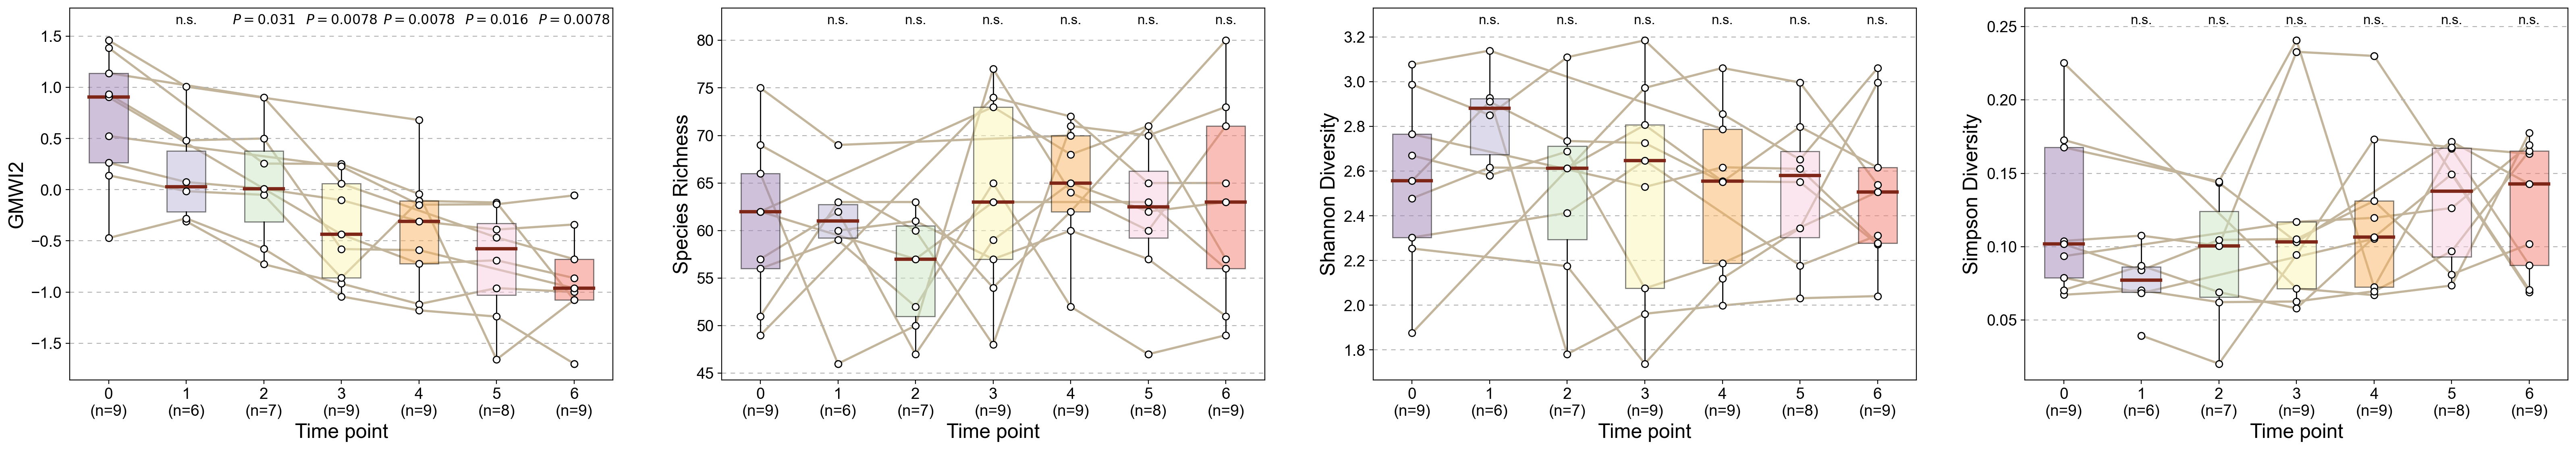

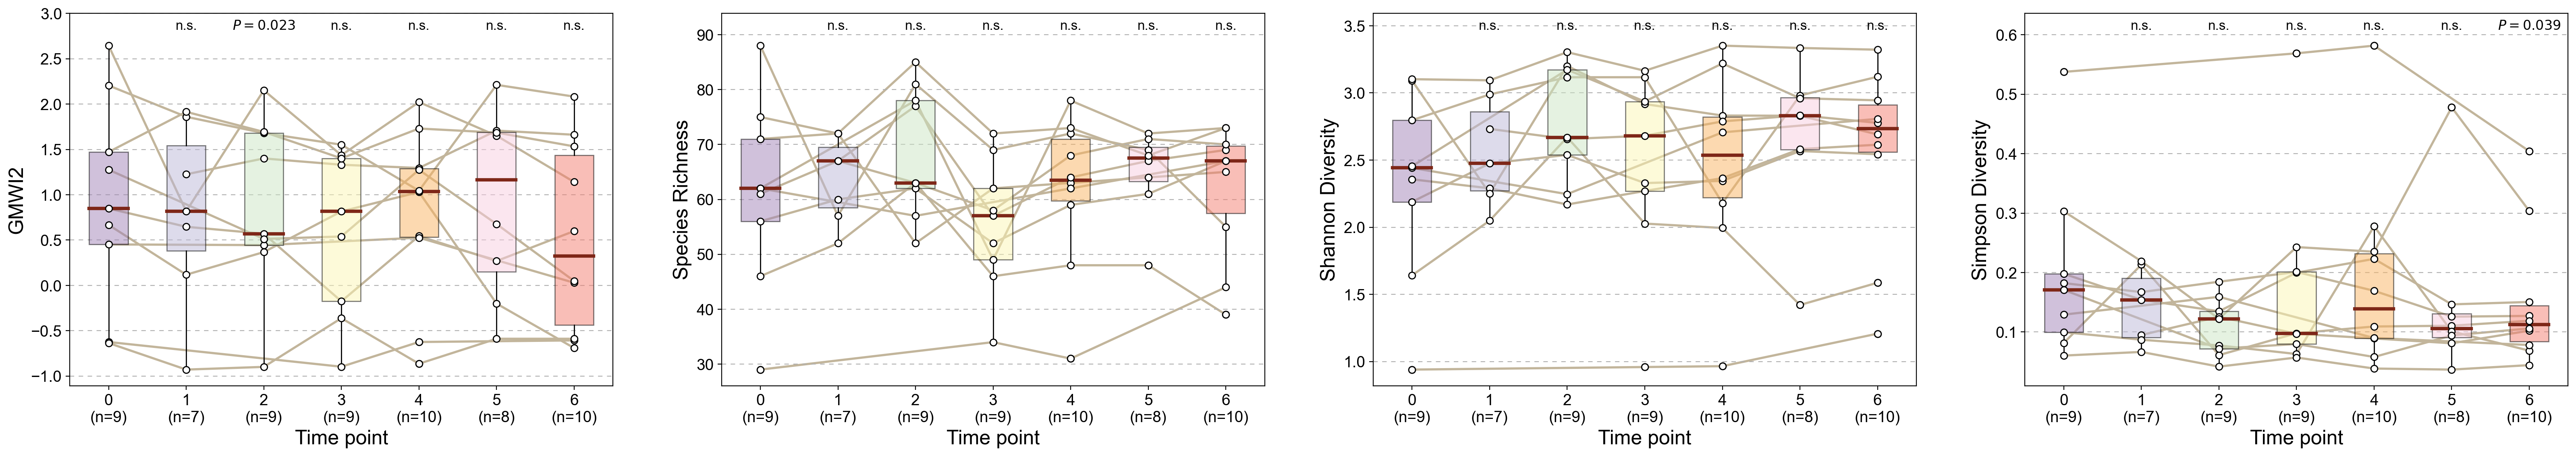

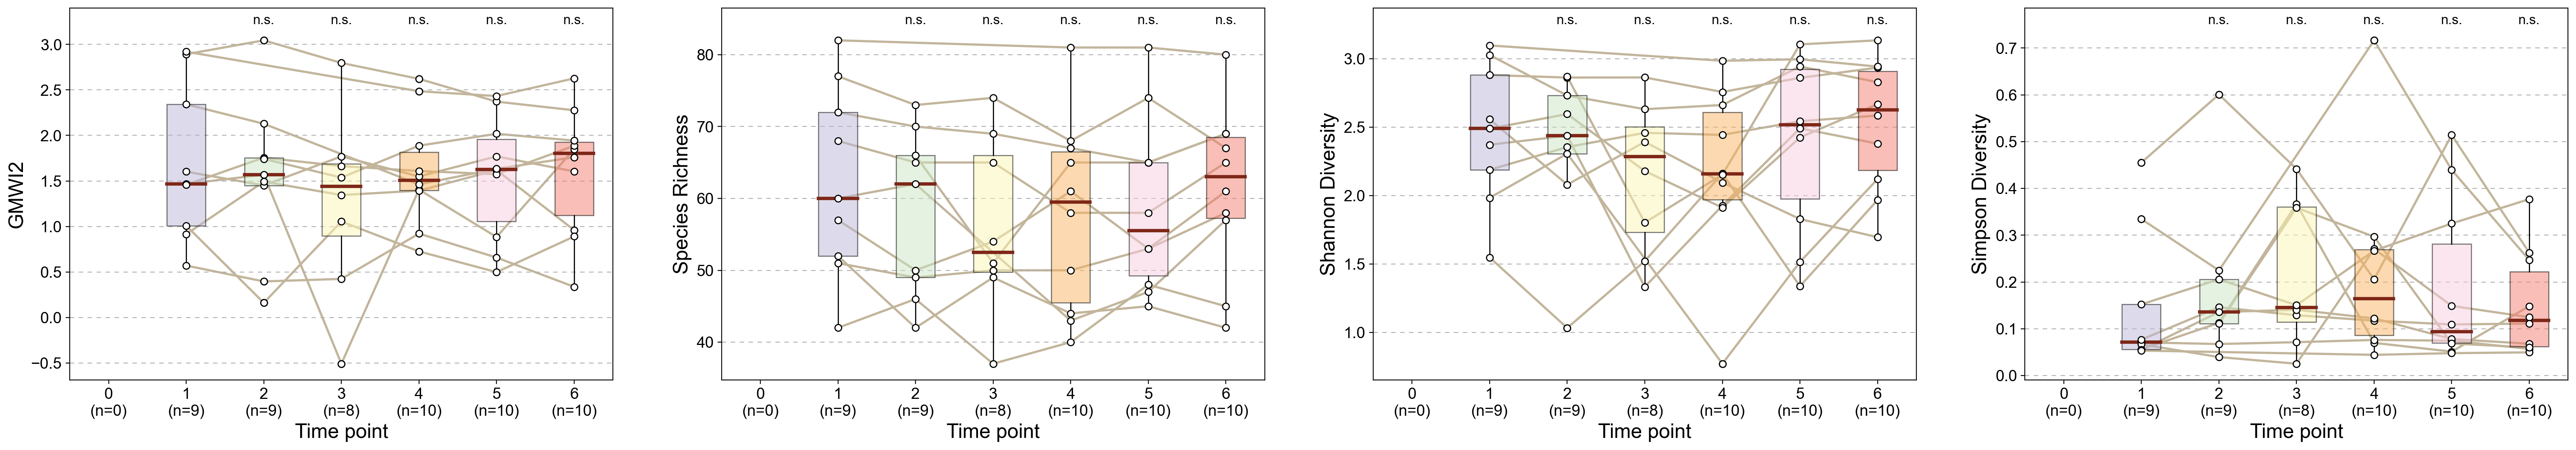

In [435]:
for diet in tanes_meta["health_status/host_diet"].unique():
    print(diet)
    meta_curr = tanes_meta.copy()
    plot_longitudinal(meta_curr[meta_curr["health_status/host_diet"] == diet], indices, timepoints_sorted, stars=False)
    

## Palleja *et al.* 2018 (Antibiotics exposure, Fig. 2e, Supplementary Table 6)

In [436]:
palleja = longitudinal_cases.loc[["Palleja (2018)"]]

In [437]:
palleja_X, palleja_meta = unpack_longitudinal_df(palleja)
display(palleja_X.head(), palleja_meta.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID       Sample Accession                                            
Palleja (2018) SAMEA104062441       0.00000                      0.00000   
               SAMEA104062442       0.00000                      0.00000   
               SAMEA104062443       0.00000                      0.00000   
               SAMEA104062444       0.00000                      0.00000   
               SAMEA104062445       0.02755                      0.02755   

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID       Sample Accession                                                   
Palleja (2018) SAMEA104062441                                           0.00000   
               SAMEA104062442                                           0.00000   
               SAMEA104062443                                           0.00000   
               SAMEA104062444                                           0.00000   
               SAMEA104062445                                           0.02755   

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID       Sample Accession                                                                         
Palleja (2018) SAMEA104062441                                              0.00000                      
               SAMEA104062442                                              0.00000                      
               SAMEA104062443                                              0.00000                      
               SAMEA104062444                                              0.00000                      
               SAMEA104062445                                              0.02755                      

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID       Sample Accession                                                                                                
Palleja (2018) SAMEA104062441                                              0.00000                                             
               SAMEA104062442                                              0.00000                                             
               SAMEA104062443                                              0.00000                                             
               SAMEA104062444                                              0.00000                                             
               SAMEA104062445                                              0.02755                                             

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID       Sample Accession                                                                                                                      
Palleja (2018) SAMEA104062441                                             0.000000                                                                   
               SAMEA104062442                                             0.000000                                                                   
               SAMEA104062443                                             0.000000                                                                   
               SAMEA104062444                                             0.000000                                                                   
               SAMEA104062445                                             0.026885                                                                   

                                 k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID       Sample Accession                       

Subject_ID health_status/host_diet timepoint
Study_ID       Sample Accession                                             
Palleja (2018) SAMEA104062441       ERAS10                 Healthy        D0
               SAMEA104062442       ERAS10                 Healthy      D180
               SAMEA104062443       ERAS10                 Healthy       D42
               SAMEA104062444       ERAS10                 Healthy        D8
               SAMEA104062445       ERAS11                 Healthy        D0

In [438]:
palleja_meta = compute_indices(palleja_meta, palleja_X)
palleja_meta = palleja_meta.set_index("Subject_ID")
palleja_meta.head()

health_status/host_diet timepoint  Species Richness  \
Subject_ID                                                       
ERAS10                     Healthy        D0                93   
ERAS10                     Healthy      D180                70   
ERAS10                     Healthy       D42                59   
ERAS10                     Healthy        D8                49   
ERAS11                     Healthy        D0               106   

            Shannon Diversity  Simpson Diversity     GMWI2  
Subject_ID                                                  
ERAS10               2.668180           0.157368  2.518271  
ERAS10               1.813468           0.308803 -1.046041  
ERAS10               1.469658           0.427027 -0.258005  
ERAS10               1.833790           0.253631 -1.006376  
ERAS11               3.100645           0.058934  2.455387

In [439]:
palleja_meta["timepoint_plot"] = [int(time[1:]) for time in palleja_meta["timepoint"]]
palleja_meta["timepoint_plot"] = palleja_meta["timepoint_plot"].apply(lambda x : {0 : 0, 4 : 1, 8 : 2, 42 : 3, 180 : 4}[x])
palleja_meta.head()

health_status/host_diet timepoint  Species Richness  \
Subject_ID                                                       
ERAS10                     Healthy        D0                93   
ERAS10                     Healthy      D180                70   
ERAS10                     Healthy       D42                59   
ERAS10                     Healthy        D8                49   
ERAS11                     Healthy        D0               106   

            Shannon Diversity  Simpson Diversity     GMWI2  timepoint_plot  
Subject_ID                                                                  
ERAS10               2.668180           0.157368  2.518271               0  
ERAS10               1.813468           0.308803 -1.046041               4  
ERAS10               1.469658           0.427027 -0.258005               3  
ERAS10               1.833790           0.253631 -1.006376               2  
ERAS11               3.100645           0.058934  2.455387               0

In [440]:
timepoints_sorted = sorted(list(palleja_meta["timepoint"].unique()), key=lambda x : int(x[1:]))
timepoints_sorted

['D0', 'D4', 'D8', 'D42', 'D180']

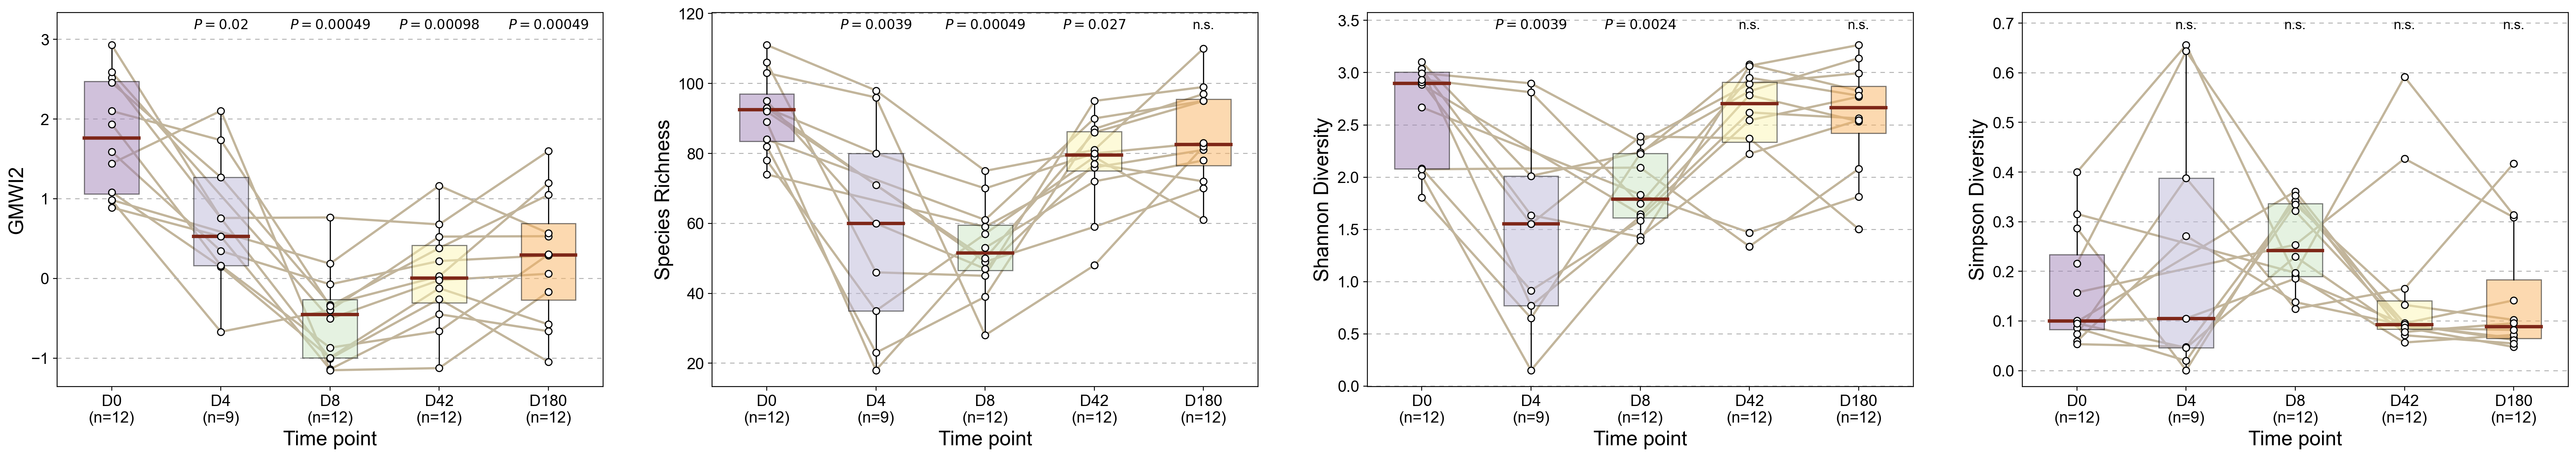

In [441]:
plot_longitudinal(palleja_meta, indices, timepoints_sorted, show_tau=False)

## Lee *et al.* 2023 (Prebiotics, Fig. 2f, Supplementary Table 7)

In [461]:
lee = longitudinal_cases.loc[["Lee (2023)"]]

In [462]:
lee_X, lee_meta = unpack_longitudinal_df(lee)
display(lee_X.head(), lee_meta.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID   Sample Accession                                            
Lee (2023) FL24_1              0.000000                     0.000000   
           XS24_2              0.000000                     0.000000   
           XS24_3              0.000000                     0.000000   
           FS24_3              0.000000                     0.000000   
           NS0_3               0.000058                     0.000058   

                             k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID   Sample Accession                                                   
Lee (2023) FL24_1                                                  0.000000   
           XS24_2                                                  0.000000   
           XS24_3                                                  0.000000   
           FS24_3                                                  0.000000   
           NS0_3                                                   0.000058   

                             k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID   Sample Accession                                                                         
Lee (2023) FL24_1                                                     0.000000                      
           XS24_2                                                     0.000000                      
           XS24_3                                                     0.000000                      
           FS24_3                                                     0.000000                      
           NS0_3                                                      0.000058                      

                             k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID   Sample Accession                                                                                                
Lee (2023) FL24_1                                                     0.000000                                             
           XS24_2                                                     0.000000                                             
           XS24_3                                                     0.000000                                             
           FS24_3                                                     0.000000                                             
           NS0_3                                                      0.000058                                             

                             k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID   Sample Accession                                                                                                                      
Lee (2023) FL24_1                                                     0.000000                                                                   
           XS24_2                                                     0.000000                                                                   
           XS24_3                                                     0.000000                                                                   
           FS24_3                                                     0.000000                                                                   
           NS0_3                                                      0.000058                                                                   

                             k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID   Sample Accession                                                                                                                                                    
Lee (2023) FL24_1 

Subject_ID health_status/host_diet timepoint
Study_ID   Sample Accession                                             
Lee (2023) FL24_1                 FL24               prebiotic         1
           XS24_2                 XS24               prebiotic         2
           XS24_3                 XS24               prebiotic         3
           FS24_3                 FS24               prebiotic         3
           NS0_3                   NS0            no substrate         3

In [463]:
lee_meta = compute_indices(lee_meta, lee_X)
lee_meta = lee_meta.reset_index().set_index("Sample Accession")
lee_meta.head()

Study_ID Subject_ID health_status/host_diet timepoint  \
Sample Accession                                                            
FL24_1            Lee (2023)       FL24               prebiotic         1   
XS24_2            Lee (2023)       XS24               prebiotic         2   
XS24_3            Lee (2023)       XS24               prebiotic         3   
FS24_3            Lee (2023)       FS24               prebiotic         3   
NS0_3             Lee (2023)        NS0            no substrate         3   

                  Species Richness  Shannon Diversity  Simpson Diversity  \
Sample Accession                                                           
FL24_1                         140           3.097957           0.075491   
XS24_2                         143           3.298212           0.068950   
XS24_3                         147           3.288295           0.070472   
FS24_3                         138           3.298019           0.060376   
NS0_3                          172           3.464496           0.045757   

                     GMWI2  
Sample Accession            
FL24_1           -0.606819  
XS24_2            0.303276  
XS24_3            0.100174  
FS24_3            0.349678  
NS0_3             0.037727

In [464]:
groups = ["NS0", "NS24", "FS24", "IN24", "GS24", "XS24", "FL24"]

group_values = {g : [float(lee_meta.loc[f"{g}_{i}"]["GMWI2"]) for i in range(1, 4)] for g in groups}

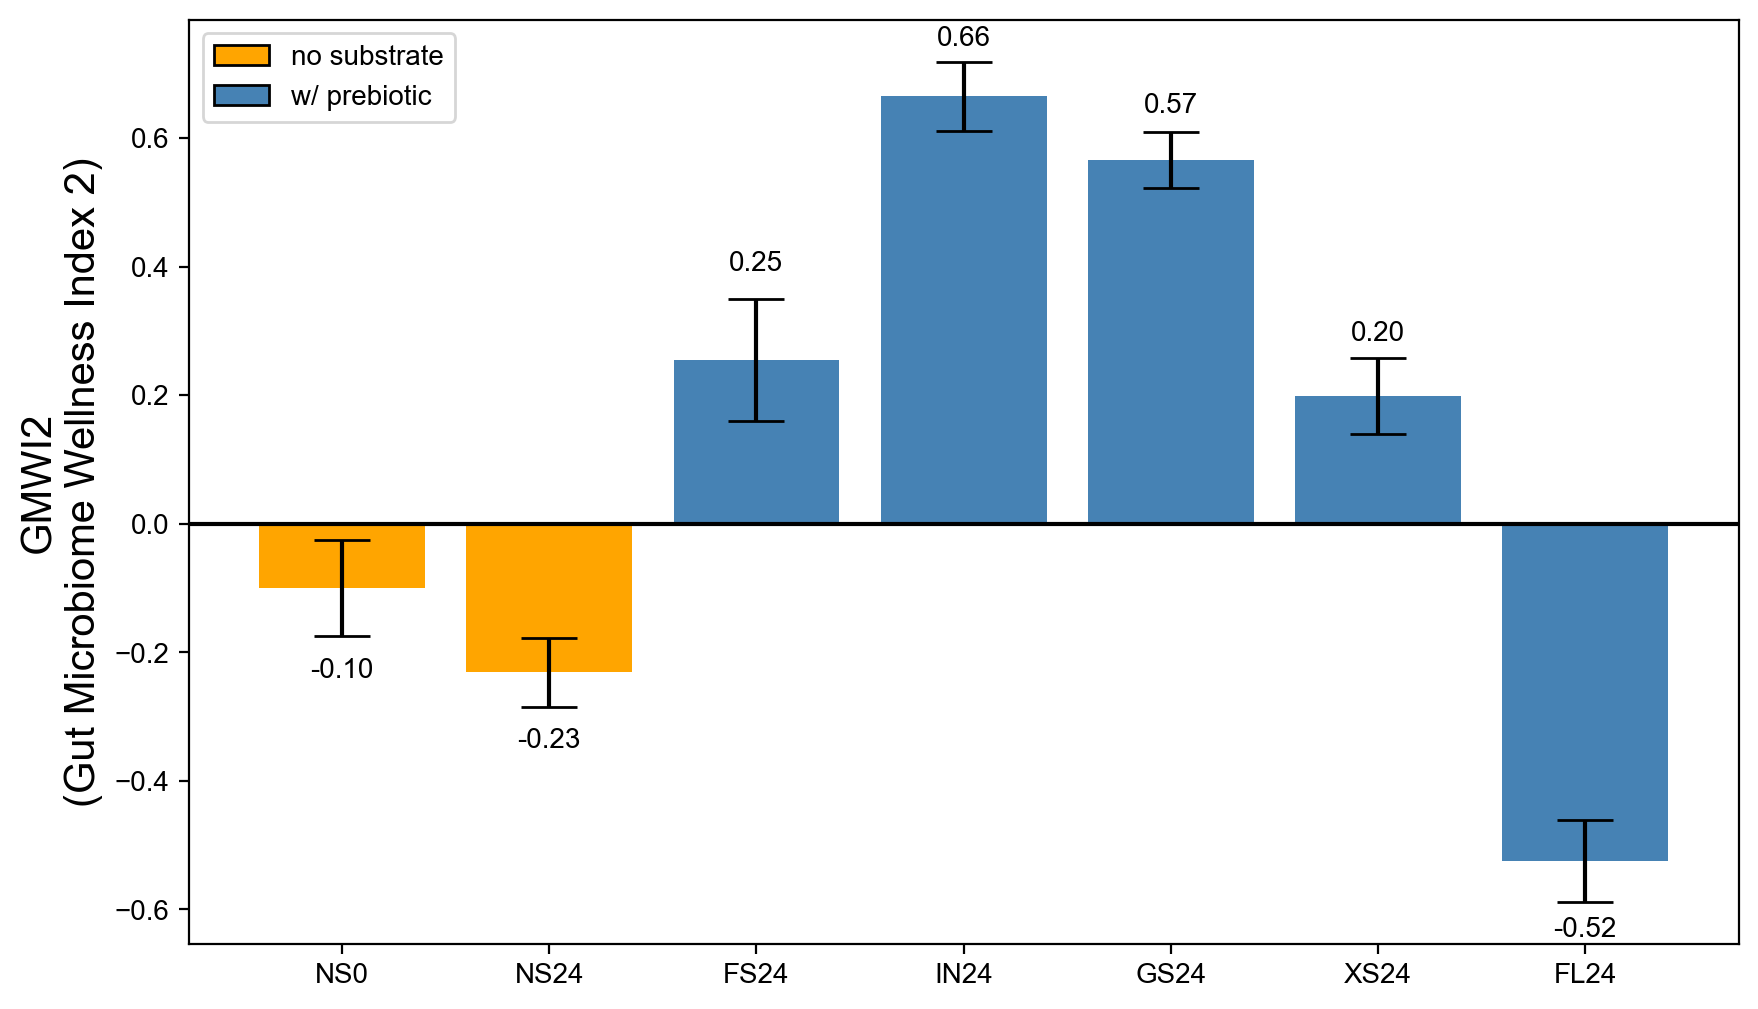

In [469]:
padding = [25, 20, 30, 16, 15, 18, 20]

plt.figure(figsize=(10, 6), dpi=200)

ax = plt.gca()

for i, g in enumerate(groups):
    color = "orange" if g.startswith("NS") else "steelblue"
    mean = np.mean(group_values[g])
    p = ax.bar(i, mean, color=color)
    plt.bar_label(p, label_type='edge', fmt="%.2f", padding=padding[i])
    
plt.axhline(y=0, color='black', linestyle='-')

legend_elements = [
    Patch(facecolor='orange', edgecolor='black', label='no substrate'),
    Patch(facecolor='steelblue', edgecolor='black', label='w/ prebiotic'),
                  ]

plt.legend(handles=legend_elements, loc=2)

y_vals = [np.mean(group_values[g]) for g in groups]
standard_errors = [sem(group_values[g]) for g in groups]

plt.errorbar(np.arange(len(groups)), y_vals, yerr=standard_errors, fmt="none", c="black", capsize=10)

plt.xticks(np.arange(len(groups)), groups)
plt.ylabel("GMWI2\n(Gut Microbiome Wellness Index 2)", fontsize=15)
    
plt.show()